In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

11452


In [2]:
save_folder = r'\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
print(len(save_filenames))
segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
cand_spots_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spots_folder):
    os.makedirs(cand_spots_folder)

42


In [3]:
figure_folder = os.path.join(save_folder, 'Figures')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")
    
cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

Use figure_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Figures
Use cand_spot_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots


## load codebook

In [4]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

name    id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0        1:3740000-3760000     1        0        0        0        0        0   
1        1:6240000-6260000     2        0        0        0        0        0   
2        1:8740000-8760000     3        0        0        0        0        0   
3      1:11240000-11260000     4        0        0        0        0        0   
4      1:13740000-13760000     5        0        0        0        0        0   
..                     ...   ...      ...      ...      ...      ...      ...   
983  X:161240000-161260000  1057        0        0        1        0        0   
984  X:163740000-163760000  1058        0        0        0        0        0   
985  X:166240000-166260000  1059        0        0        0        0        0   
986  X:168740000-168760000  1060        0        0        0        0        0   
987      Y:1240000-1260000  1062        0        0        0        0        0   

     NDB_725  NDB_817  NDB_710  ...  NDB_824  NDB_712  NDB_818  NDB_940  \
0          0        0        0  ...        0        0        0        0   
1          0        0        0  ...        0        0        0        0   
2          0        0        0  ...        0        0        0        0   
3          0        0        0  ...        0        0        0        1   
4          0        0        0  ...        0        0        1        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
983        0        0        0  ...        0        0        0        0   
984        0        0        0  ...        0        0        0        0   
985        1        0        0  ...        0        0        0        0   
986        0        0        0  ...        0        0        0        0   
987        0        0        1  ...        0        0        0        0   

     NDB_872  NDB_934  NDB_926  NDB_910  chr  chr_order  
0          0        0        0        0    1          0  
1          0        0        0        0    1          1  
2          0        0        0        0    1          2  
3          0        0        0        0    1          3  
4          0        0        0        0    1          4  
..       ...      ...      ...      ...  ...        ...  
983        0        1        0        0    X         52  
984        1        0        0        0    X         53  
985        0        0        0        0    X         54  
986        0        0        0        0    X         55  
987        0        0        0        0    Y          0  

[988 rows x 103 columns]

In [5]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

## spots

In [6]:
spot_filenames = [os.path.join(cand_spot_folder, _fl) for _fl in os.listdir(cand_spot_folder)]
print(len(spot_filenames))

4689


In [7]:
cand_cell_dict = pickle.load(open(spot_filenames[-1], 'rb'))
cand_cell_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [8]:
import multiprocessing as mp
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [9]:
from ImageAnalysis3.classes.preprocess import Spots3D

In [1117]:
%%time
import multiprocessing as mp
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

decode_args = [(_fl, codebook_df, None, 
                False, None,
                pixel_sizes, 2, 0.5, 
                200, -1, 1, 5, 0, -25, False, overwrite) for _fl in spot_filenames[:]
               if not os.path.exists(_fl.replace('CandSpots', 'Decoder'))
              ]
print(len(decode_args))

with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args[:], chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

3346
Wall time: 1h 30min 53s


In [10]:
reload(decode)
combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}
pair_search_radius = 250
pixel_sizes = [250,108,108]

In [ ]:
%%time
decode_args = [(_fl, codebook_df, None, True, True, id_2_channel,
                pixel_sizes, 2, 0.5, pair_search_radius, np.array([1,1,1,1,1]))
               for _fl in spot_filenames[:]]

print(len(decode_args))
    
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_BB_like, decode_args, chunksize=1)
    decode_pool.closeb
    decode_pool.join()
    decode_pool.terminate()

4689


## load decode results

In [11]:
decode_folder = os.path.join(save_folder, 'BBDecoder')
#decode_folder = os.path.join(save_folder, 'Decoder')
decode_files = [os.path.join(decode_folder, _fl) for _fl in os.listdir(decode_folder) 
                if _fl.split(os.path.extsep)[-1]=='pkl']
print(len(decode_files))

478


In [12]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decode_files[:]]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

478
478
Wall time: 34.1 s


In [13]:
%%time
import multiprocessing as mp

summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool:
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

Wall time: 1min 11s


## Median distance map

In [14]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys_list = np.concatenate(all_zxys_list)

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys_list)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 956/956 [00:36<00:00, 26.30it/s]


Wall time: 1min 35s


In [15]:
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


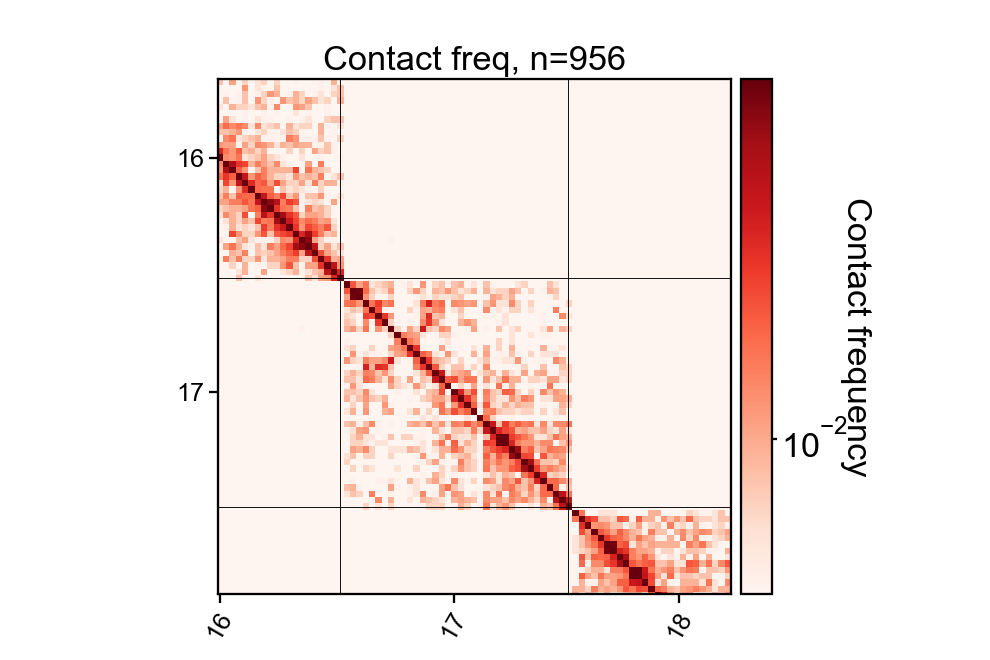

E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)


In [28]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.005, 0.05]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)





#fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


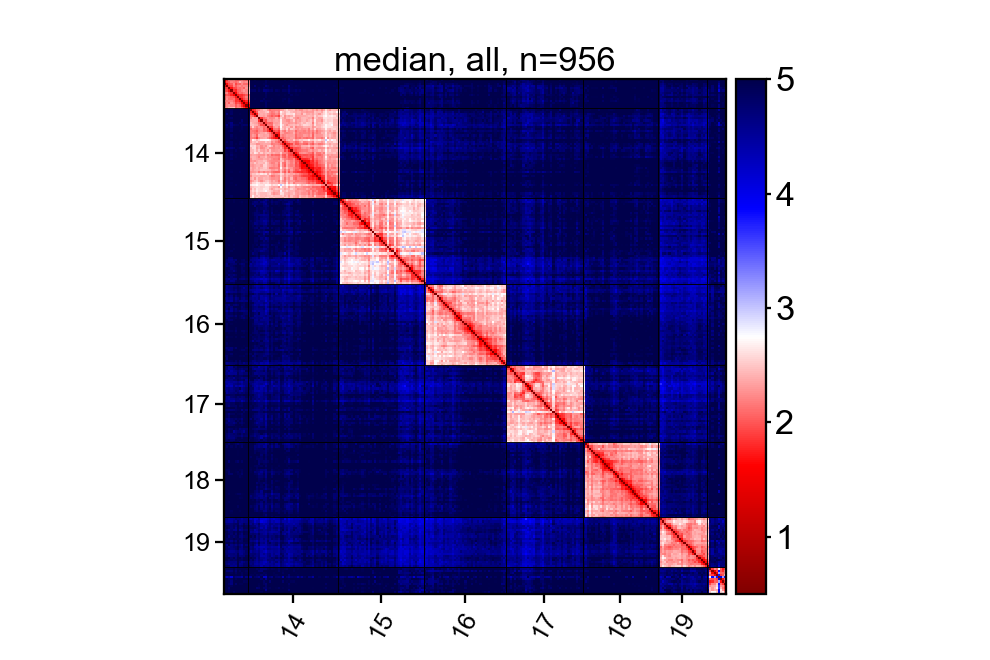

In [26]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.5,5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)

#fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()

## match with Hi-C

In [29]:
hic_folder = r'\\10.245.74.212\Chromatin_NAS_3\hic_map_ctp11_regions_1000-loci'

hic_files = [os.path.join(hic_folder, _fl) 
             for _fl in os.listdir(hic_folder) 
             if _fl.split(os.extsep)[-1]=='npy' and 'compressed' in _fl]
chr_2_hic = {}
for _fl in hic_files:
    _chr_name = _fl.split(".npy")[0].split("chr_")[1]
    chr_2_hic[_chr_name] = np.load(_fl)
    
chr_2_contact = {}
for _chr_name in np.unique(codebook_df['chr']):
    _chr_inds = np.array(codebook_df.index[codebook_df['chr']==_chr_name])
    chr_2_contact[_chr_name] = contactmap[_chr_inds][:,_chr_inds]

In [30]:
chr_2_median = {}
for _chr_name in np.unique(codebook_df['chr']):
    _chr_inds = np.array(codebook_df.index[codebook_df['chr']==_chr_name])
    chr_2_median[_chr_name] = median_distmap[_chr_inds][:,_chr_inds]

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


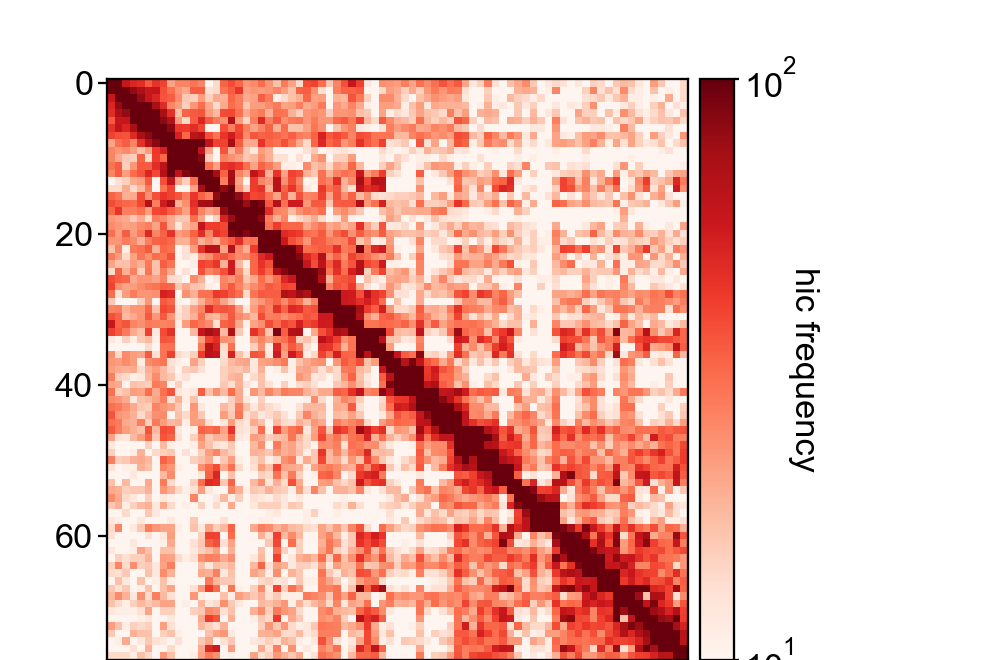

<AxesSubplot:>

In [32]:
hic_limits = [10, 100]
#hic_limits = [0.001, 0.3]
hic_norm = LogNorm(vmin=np.min(hic_limits), 
                       vmax=np.max(hic_limits))
hic_cmap = cm.get_cmap('Reds')
hic_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    chr_2_hic['1'], 
    cmap=hic_cmap,
    color_limits=hic_limits,
    color_norm=hic_norm,
    colorbar_labels='hic frequency',
    ax=ax,
)

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


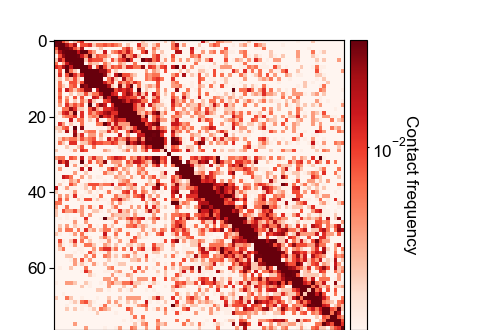

<AxesSubplot:>

In [36]:
contact_limits = [0.005, 0.015]
#contact_limits = [0.001, 0.3]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=150)

ia.figure_tools.distmap.plot_distance_map(
    chr_2_contact['1'], 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

In [37]:
contact_val_list, hic_val_list = [], []
for _chr_name in chr_2_hic:
    _ix,_iy = np.triu_indices(len(chr_2_contact[_chr_name]), 1)
    contact_vals = chr_2_contact[_chr_name][_ix,_iy]
    hic_vals = chr_2_hic[_chr_name][_ix,_iy]
    
    contact_val_list.append(contact_vals)
    hic_val_list.append(hic_vals)
contact_val_list = np.concatenate(contact_val_list)
hic_val_list = np.concatenate(hic_val_list)

In [49]:
median_val_list, hic_val_list = [], []
for _chr_name in chr_2_hic:
    _ix,_iy = np.triu_indices(len(chr_2_median[_chr_name]), 1)
    median_vals = chr_2_median[_chr_name][_ix,_iy]
    hic_vals = chr_2_hic[_chr_name][_ix,_iy]
    
    median_val_list.append(median_vals)
    hic_val_list.append(hic_vals)
median_val_list = np.concatenate(median_val_list)
hic_val_list = np.concatenate(hic_val_list)

<IPython.core.display.Javascript object>


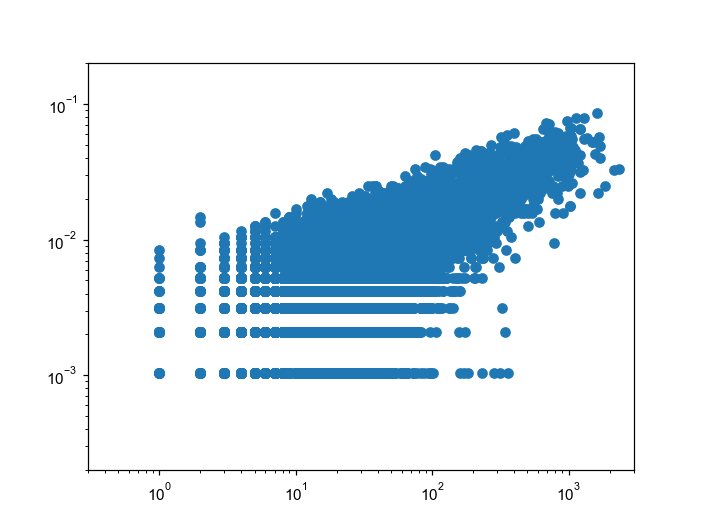

(0.0002, 0.2)

In [43]:
fig,ax = plt.subplots()
ax.scatter(hic_val_list, contact_val_list, )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.3,3000])
ax.set_ylim([0.0002,0.2])

In [57]:
from sklearn.linear_model import LinearRegression
valid_inds = (contact_val_list > 0 ) * (hic_val_list > 0)

_x = np.log(hic_val_list[valid_inds])[:,np.newaxis]
_y = np.log(contact_val_list[valid_inds])

_reg = LinearRegression().fit(_x,_y)

In [59]:
_reg.score(_x,_y), _reg

0.2995125787967796

<IPython.core.display.Javascript object>


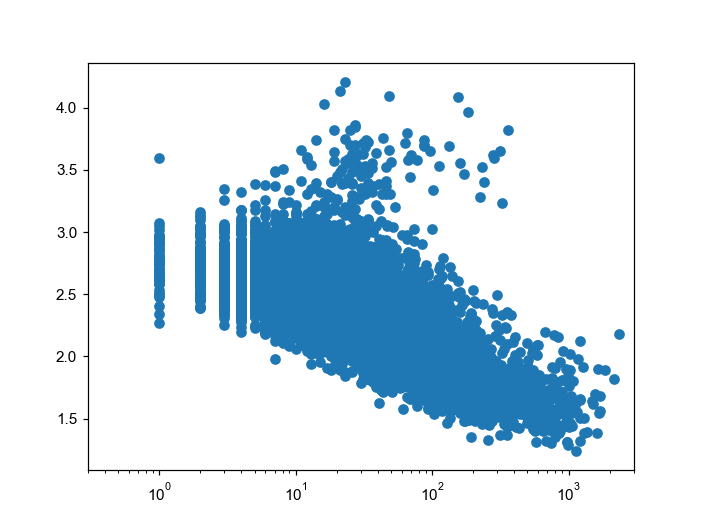

In [63]:
fig,ax = plt.subplots()
ax.scatter(hic_val_list, median_val_list, )

ax.set_xscale('log')
ax.set_xlim([0.3,3000])
fig.show()

In [60]:
from sklearn.linear_model import LinearRegression
valid_inds = (contact_val_list > 0 ) * (hic_val_list > 0)

_x = np.log(hic_val_list[valid_inds])[:,np.newaxis]
_y = (median_val_list[valid_inds])

_reg = LinearRegression().fit(_x,_y)

In [64]:
np.sqrt(_reg.score(_x,_y)), _reg.coef_

(0.6659186310795806, array([-0.19133972]))

In [ ]:
_reg.

In [1094]:
np.save(os.path.join(save_folder, 'median_distmap_v0'), median_distmap)

In [1095]:
np.save(os.path.join(save_folder, 'contact_map_500_v0'), contactmap)

## Test parameaters

In [1030]:
import multiprocessing as mp
from ImageAnalysis3.classes import decode
reload(decode)
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [1031]:
combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}

In [1032]:
pixel_sizes = [250,108,108]

cand_spots = decode.spots_dict_to_cand_spots(spot_filenames[1], normalize_intensity=True, id_2_channel=id_2_channel)

decoder = decode.DNA_Merfish_Decoder(codebook_df, cand_spots,
                              pixel_sizes=pixel_sizes, valid_score_th=-25,
                              savefile=spot_filenames[1].replace('CandSpots','Decoder'),
                              ct_dist_factor=5, local_dist_factor=0,
                              load_from_file=False,
                              )



In [1033]:
_overwrite = True
pair_search_radius = 200

decoder.prepare_spot_tuples(pair_search_radius=pair_search_radius, overwrite=_overwrite)
decoder.prepare_chr_trees()

#invalid_groups = decoder.generate_random_invalid_pairs()

4926 pairs kept given search radius 200 nm.


4926it [00:08, 604.71it/s]


- 2992 spot groups selected. 
- split found tuples into chromosomes. 
- generate randomized spot pairs 


In [1034]:
# chr_2_init_centers
decoder.chr_2_homolog_centers = {}
for _chr_name in decoder.chr_2_groups:
    print(_chr_name)
    _chr_zxys = np.array([_g.centroid_spot().to_positions()[0] for _g in decoder.chr_2_groups[_chr_name]])
    _chr_inds = np.array([_g.chr_order for _g in decoder.chr_2_groups[_chr_name]])
    _centers = np.array(decode.init_homolog_centers_BB(_chr_zxys, _chr_inds))
    decoder.chr_2_homolog_centers[_chr_name] = _centers

1
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9
X


In [1035]:
%%time
reload(decode)
valid_metrics_list = decoder.calculate_score_metrics()

-- generate scoring metrics for chr:1
(225, 3)
(3,)
(225, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:10
(155, 3)
(3,)
(155, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:11
(141, 3)
(3,)
(141, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:12
(133, 3)
(3,)
(133, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:13
(136, 3)
(3,)
(136, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:14
(135, 3)
(3,)
(135, 3)
(3,)
(1972, 3)
(3,)
(1972, 3)
(3,)
-- generate scoring metrics for chr:15
(105, 3)
(3,)
(105, 3)
(3,)
(1142, 3)
(3,)
(1142, 3)
(3,)
-- generate scoring metrics for chr:16
(129, 3)
(3,)
(129, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:17
(120, 3)
(3,)
(120, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:18
(123, 3)
(3,)
(123, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for

In [1036]:
%%time
valid_metrics_list = decoder.calculate_score_metrics(_n_neighbors=10)

-- generate scoring metrics for chr:1
(225, 3)
(3,)
(225, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:10
(155, 3)
(3,)
(155, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:11
(141, 3)
(3,)
(141, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:12
(133, 3)
(3,)
(133, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:13
(136, 3)
(3,)
(136, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:14
(135, 3)
(3,)
(135, 3)
(3,)
(1972, 3)
(3,)
(1972, 3)
(3,)
-- generate scoring metrics for chr:15
(105, 3)
(3,)
(105, 3)
(3,)
(1142, 3)
(3,)
(1142, 3)
(3,)
-- generate scoring metrics for chr:16
(129, 3)
(3,)
(129, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:17
(120, 3)
(3,)
(120, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for chr:18
(123, 3)
(3,)
(123, 3)
(3,)
(2000, 3)
(3,)
(2000, 3)
(3,)
-- generate scoring metrics for

In [1037]:
%%time
reload(decode)
chr_2_valid_scores, chr_2_invalid_scores = decoder.calculate_scores(valid_metrics_list)

-- scoring spot_groups for chr:1
-- scoring spot_groups for chr:10
-- scoring spot_groups for chr:11
-- scoring spot_groups for chr:12
-- scoring spot_groups for chr:13
-- scoring spot_groups for chr:14
-- scoring spot_groups for chr:15
-- scoring spot_groups for chr:16
-- scoring spot_groups for chr:17
-- scoring spot_groups for chr:18
-- scoring spot_groups for chr:19
-- scoring spot_groups for chr:2
-- scoring spot_groups for chr:3
-- scoring spot_groups for chr:4
-- scoring spot_groups for chr:5
-- scoring spot_groups for chr:6
-- scoring spot_groups for chr:7
-- scoring spot_groups for chr:8
-- scoring spot_groups for chr:9
-- scoring spot_groups for chr:X
Wall time: 6.15 s


In [947]:
# update 

In [956]:
def prepare_homolog_trees(self, chr_2_zxys_list, )

-10.04573523883997

In [1075]:
#_chr_name = '1'
weights = np.array([1,1,1,2,2])
decoder.chr_2_zxys_list = {}
decoder.chr_2_chr_centers = {}

for _chr_name in decoder.chr_2_valid_scores:
    print(_chr_name)
    valid_final_scores = summarize_score(decoder.chr_2_valid_scores[_chr_name], weights)
    invalid_final_scores = summarize_score(decoder.chr_2_invalid_scores[_chr_name], weights)
    score_th = scoreatpercentile(invalid_final_scores, 99.9)

    homolog_2_groups = {_i:[] for _i,_ct in enumerate(decoder.chr_2_homolog_centers[_chr_name])}
    for _g in decoder.chr_2_groups[_chr_name]:
        _final_h_sc = decode.summarize_score(_g.scores, weights=weights)
        _g.final_scores = _final_h_sc
        ihomo = np.argmax(_final_h_sc)
        _g.final_score = np.max(_final_h_sc)
        homolog_2_groups[ihomo].append(_g)
        #print(_final_h_sc, ihomo, _g.chr_order)

    for _ihomo, _tps in homolog_2_groups.items():
        homolog_2_groups[_ihomo] = [_g for _g in sorted(_tps, key=lambda v:v.chr_order)]


    homolog_2_tp_list = {}
    for _ihomo, _tps in homolog_2_groups.items():
        _tp_list = []
        _chr_region_ids = decoder.extract_chr_region_ids(decoder.codebook, _chr_name)
        
        for _chr_id in _chr_region_ids:
            _matched_tps = [_g for _g in _tps if _g.chr_order==_chr_id]
            if len(_matched_tps) == 0:
                _tp_list.append(None)
            #print(len(_matched_tps))
            #print([_g.final_scores[_ihomo] for _g in _matched_tps], np.argmax([_g.final_scores[_ihomo] for _g in _matched_tps]))
            else:
                _tp_list.append(_matched_tps[np.argmax([_g.final_scores[_ihomo] for _g in _matched_tps])])
        homolog_2_tp_list[_ihomo] = _tp_list

    homolog_zxys_list = [decode.DNA_Merfish_Decoder.tuple_list_to_zxys(_tps, score_th=-6) 
                         for _ihomo, _tps in homolog_2_tp_list.items()]
    #print(homolog_zxys_list[0].shape, homolog_zxys_list[0].shape)
    # save
    decoder.chr_2_zxys_list[_chr_name] = homolog_zxys_list
    decoder.chr_2_chr_centers[_chr_name] = np.array([np.nanmean(_zxys, axis=0) for _zxys in homolog_zxys_list]) 

1
(77, 3) (77, 3)
10
(51, 3) (51, 3)
11
(48, 3) (48, 3)
12
(43, 3) (43, 3)
13
(45, 3) (45, 3)
14
(42, 3) (42, 3)
15
(40, 3) (40, 3)
16
(38, 3) (38, 3)
17
(36, 3) (36, 3)
18
(35, 3) (35, 3)
19
(23, 3) (23, 3)
2
(70, 3) (70, 3)
3
(61, 3) (61, 3)
4
(59, 3) (59, 3)
5
(58, 3) (58, 3)
6
(58, 3) (58, 3)
7
(49, 3) (49, 3)
8
(50, 3) (50, 3)
9
(48, 3) (48, 3)
X
(56, 3) (56, 3)


In [1080]:
test_figure_folder = os.path.join(figure_folder, 'Tests')
if not os.path.exists(test_figure_folder):
    os.makedirs(test_figure_folder)

<IPython.core.display.Javascript object>


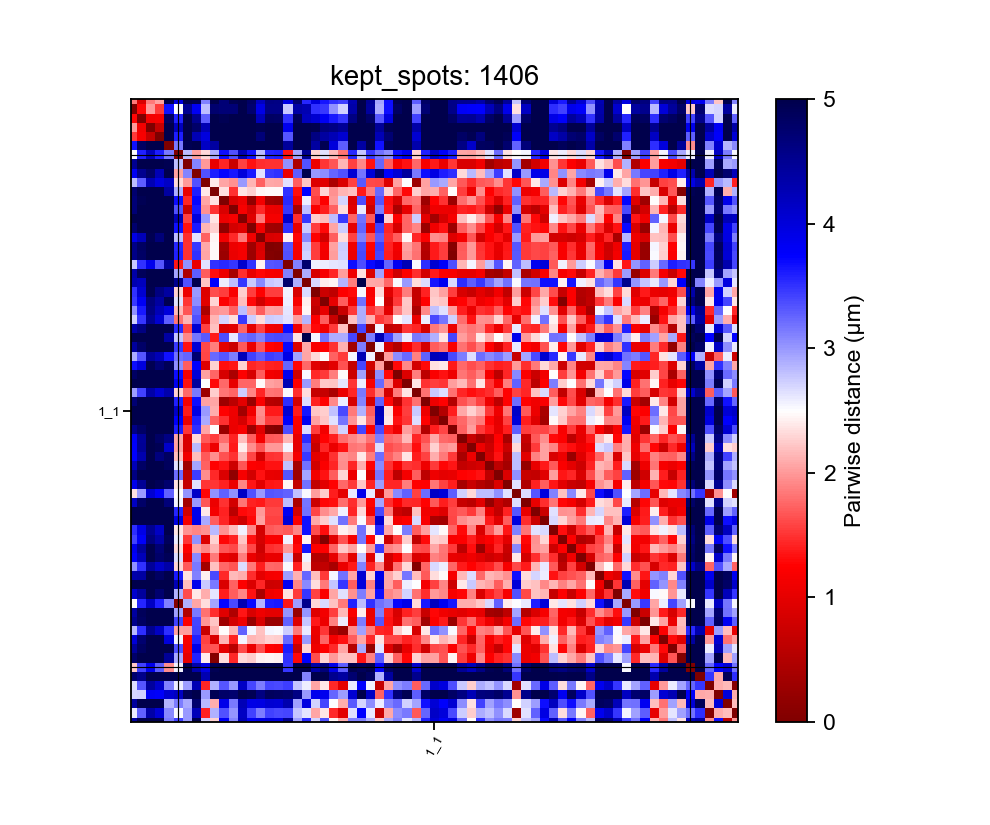

In [1125]:
figure_zxys_list, figure_labels, figure_label_ids = decoder.summarize_zxys_all_chromosomes(keep_valid=True)
_ax = decoder.summarize_to_distmap(decoder, color_limits=[0,5], save_filename=os.path.join(test_figure_folder, 'test_scmap.png'))

<IPython.core.display.Javascript object>


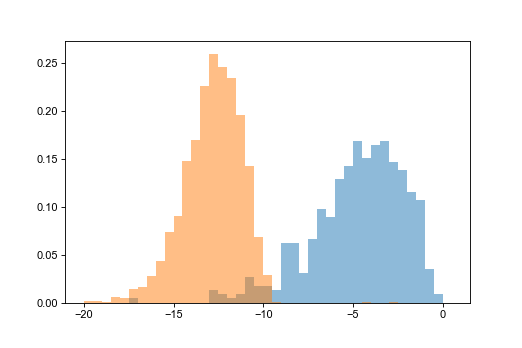

In [1068]:
from scipy.stats import scoreatpercentile
plt.figure()
plt.hist(valid_final_scores, bins=np.arange(-20,1,0.5), density=True, alpha=0.5)
plt.hist(invalid_final_scores, bins=np.arange(-20,1,0.5), density=True, alpha=0.5)
plt.show()

In [1071]:
scoreatpercentile(valid_final_scores, 20)

-6.665371099327263

In [1127]:
_chr_name = '1'

1058

In [1141]:
id_2_zxys = []
for _id_name in [1,2,3,4]:
    id_2_zxys.append( np.array([_g.centroid_spot().to_positions()[0] for _g in decoder.spot_groups if _g.tuple_id == _id_name]))

<IPython.core.display.Javascript object>


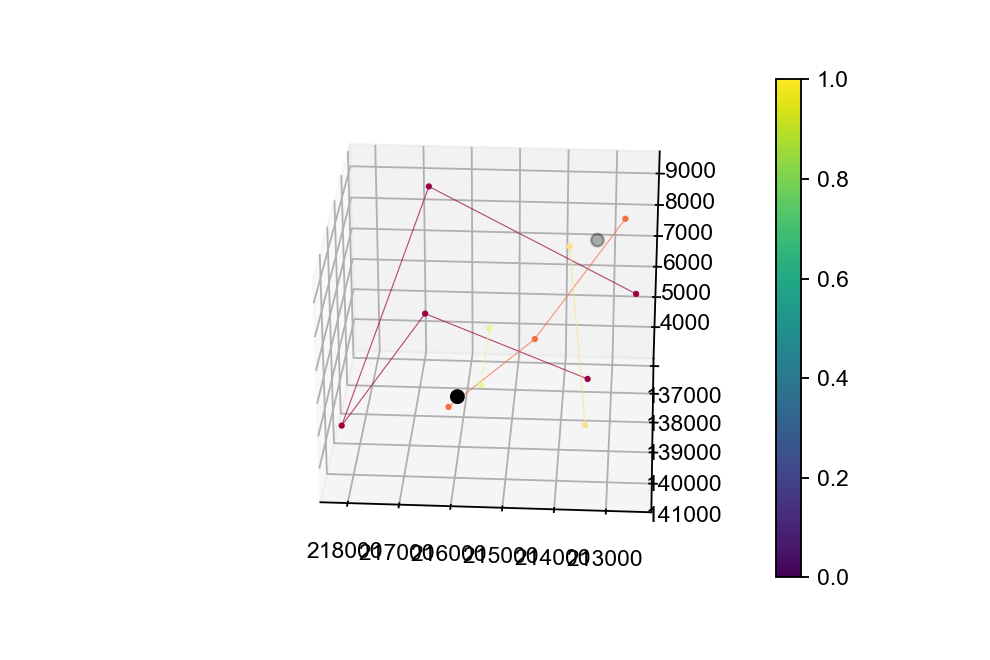

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[[  5351.0184288  213440.12841797 140130.29003906]
 [  5828.45211029 216813.45410156 138518.72753906]
 [  5031.97431564 218122.17626953 141553.35351562]
 [  9267.89569855 216780.93017578 137813.55029297]
 [  5910.76135635 212532.66210938 137675.47851562]]
[[  4671.77724838 216161.27490234 140475.06738281]
 [  5910.14480591 214525.91601562 139417.62451172]
 [  8335.59989929 212789.42578125 137724.99609375]]
[[  7688.73071671 213902.37158203 138050.18261719]
 [  3373.63600731 213490.92480469 139592.25439453]]
[[  6078.34434509 215443.71826172 139253.69970703]
 [  5368.33953857 215522.31884766 140455.56884766]]


In [1143]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d',)

_zxys_list = id_2_zxys
#_centers = decoder.chr_2_homolog_centers[_chr_name]

for _ichr, _zxys in enumerate(_zxys_list):
    print(_zxys)
    _pf = ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap='Spectral', 
               #c=homolog_score_list[_ichr],
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               depthshade=True,
                     vmax=0, vmin=-8,
               alpha=1,
               
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )


    
ax.scatter(_centers[:,1], _centers[:,2], _centers[:,0],
           cmap=Spectral, 
           color=[0,0,0],
           s=30)


plt.colorbar(_pf)
plt.show()

<IPython.core.display.Javascript object>


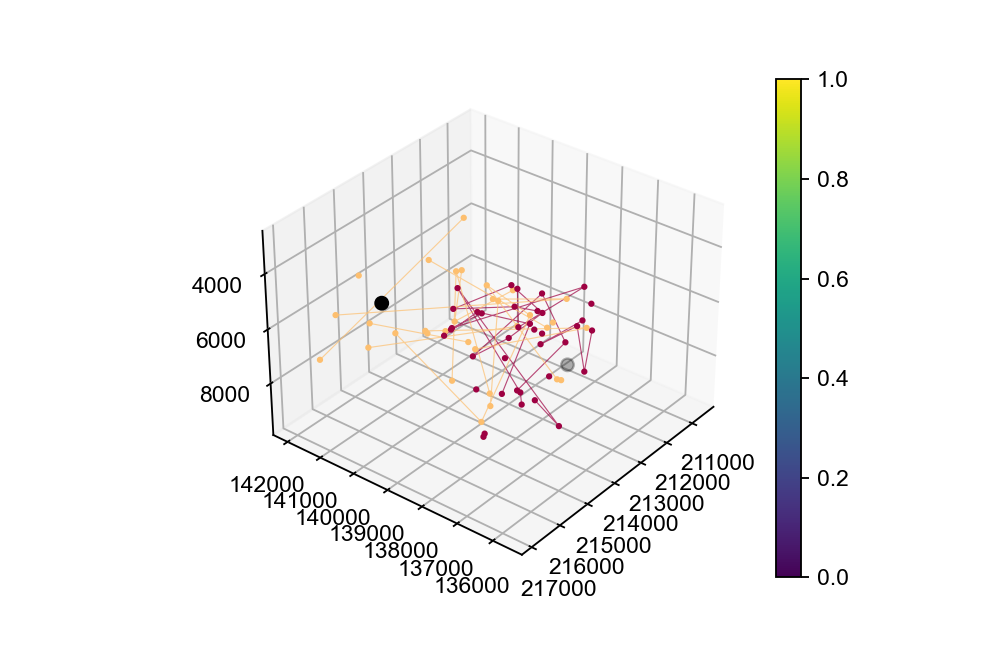

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [1128]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d',)

_zxys_list = homolog_zxys_list
_centers = decoder.chr_2_homolog_centers[_chr_name]

for _ichr, _zxys in enumerate(_zxys_list):
    
    _pf = ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap='Spectral', 
               #c=homolog_score_list[_ichr],
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               depthshade=True,
                     vmax=0, vmin=-8,
               alpha=1,
               
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )


    
ax.scatter(_centers[:,1], _centers[:,2], _centers[:,0],
           cmap=Spectral, 
           color=[0,0,0],
           s=30)


plt.colorbar(_pf)
plt.show()

In [876]:
# save
pickle.dump(decoder, open(os.path.join(decode_folder,'test_decoder.pkl'), 'wb'))

PicklingError: Can't pickle <class 'ImageAnalysis3.classes.decode.DNA_Merfish_Decoder'>: it's not the same object as ImageAnalysis3.classes.decode.DNA_Merfish_Decoder

In [669]:
valid_metrics_list = calculate_score_metrics(decoder)

-- generate scoring metrics for chr:1
-- generate scoring metrics for chr:10
-- generate scoring metrics for chr:11
-- generate scoring metrics for chr:12
-- generate scoring metrics for chr:13
-- generate scoring metrics for chr:14
-- generate scoring metrics for chr:15
-- generate scoring metrics for chr:16
-- generate scoring metrics for chr:17
-- generate scoring metrics for chr:18
-- generate scoring metrics for chr:19
-- generate scoring metrics for chr:2
-- generate scoring metrics for chr:3
-- generate scoring metrics for chr:4
-- generate scoring metrics for chr:5
-- generate scoring metrics for chr:6
-- generate scoring metrics for chr:7
-- generate scoring metrics for chr:8
-- generate scoring metrics for chr:9
-- generate scoring metrics for chr:X
-- generate scoring metrics for chr:Y


In [701]:
def summarize_score(scores, weights=None, update_attr=True):
    if weights is None:
        weights = np.ones(np.shape(scores)[-1])
    final_scores = np.nansum(scores * np.ones(5), axis=-1)

    return final_scores

In [700]:
scores_list[0]

array([-1.39971738, -1.87514108, -0.17171138, -0.68429757,         nan])

In [705]:
summarize_score(scores_list[1],)

-1.3361097978029268

<IPython.core.display.Javascript object>


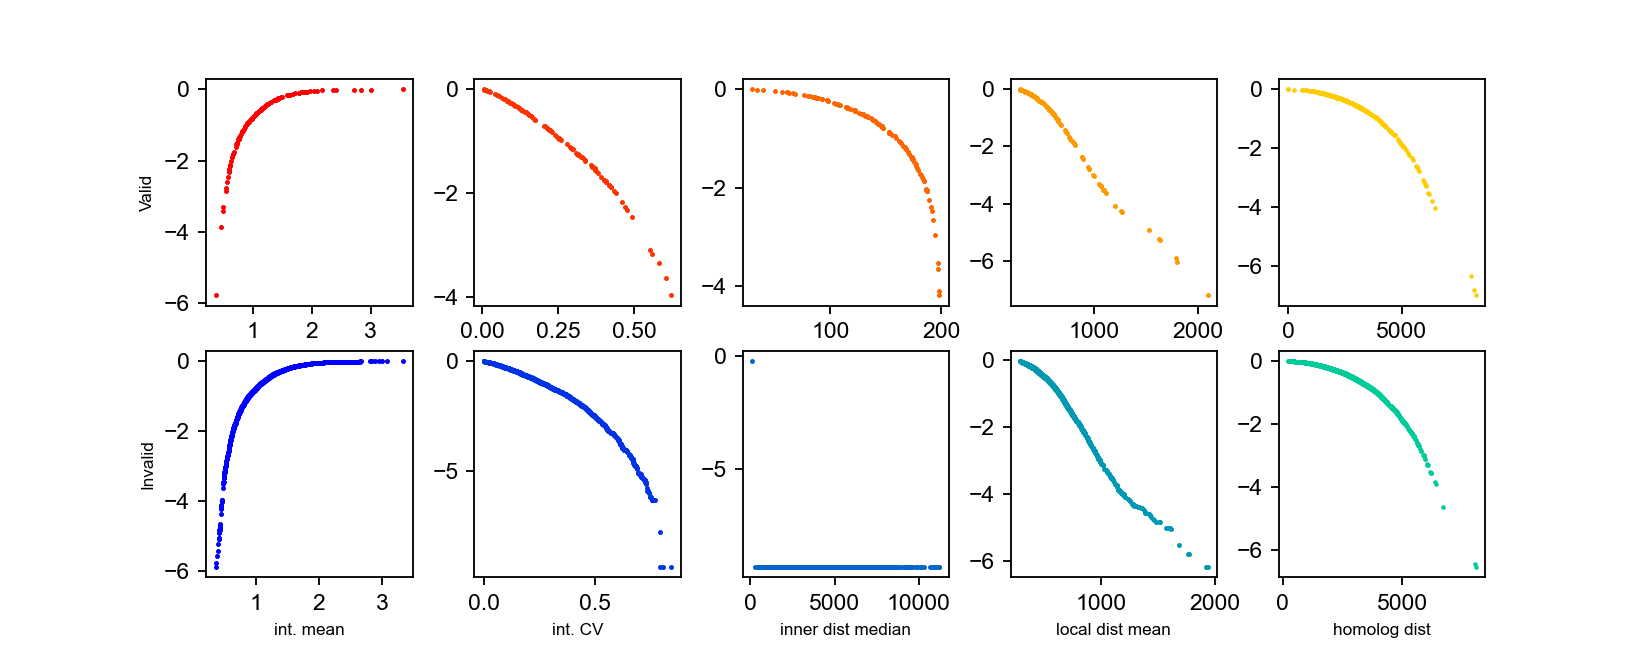

In [924]:
#_chr_name = '1'

metric_names = ['int. mean', 'int. CV', 'inner dist median', 'local dist mean', 'homolog dist']
valid_metrics_list = collect_metrics(decoder.chr_2_groups[_chr_name])
valid_scores_list = decoder.chr_2_valid_scores[_chr_name]

invalid_metrics_list = collect_metrics(decoder.chr_2_invalid_groups[_chr_name])
invalid_scores_list = decoder.chr_2_invalid_scores[_chr_name]



num_score_metrics = len(valid_scores_list.transpose())
cmap = cm.Spectral

fig, axes_list = plt.subplots(2,num_score_metrics, figsize=(num_score_metrics*2, 4), dpi=150)
for _iax, _ax in enumerate(axes_list[0]):
    _ax.scatter(np.array(valid_metrics_list).transpose()[_iax], 
                valid_scores_list.transpose()[_iax], 
                s=1, color=cm.autumn(_iax / num_score_metrics),
                label='valid')
axes_list[0][0].set_ylabel("Valid", fontsize=7.5)
for _iax, _ax in enumerate(axes_list[1]):

    _ax.scatter(np.array(invalid_metrics_list).transpose()[_iax], 
                invalid_scores_list.transpose()[_iax], 
                s=1, color=cm.winter(_iax / num_score_metrics),
                label='invalid')
    _ax.set_xlabel(metric_names[_iax], fontsize=7.5)
axes_list[1][0].set_ylabel("Invalid", fontsize=7.5)

fig.subplots_adjust(wspace=0.3)
fig.show()

<IPython.core.display.Javascript object>


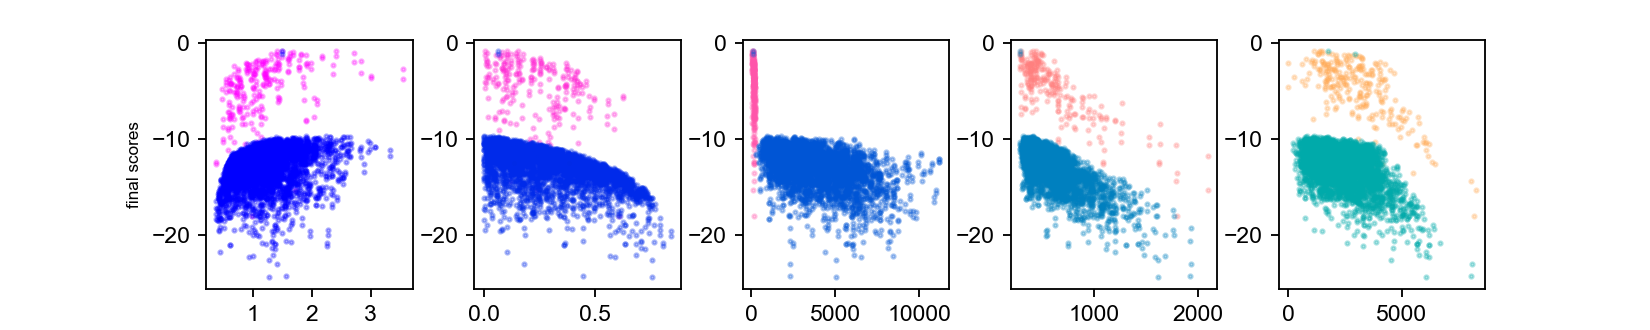

In [925]:

# final scores
valid_final_scores = summarize_score(valid_scores_list)
invalid_final_scores = summarize_score(invalid_scores_list)

fig, axes = plt.subplots(1,num_score_metrics, figsize=(num_score_metrics*2,2), dpi=150)
axes[0].set_ylabel("final scores", fontsize=7.5)
#
for _iax, (_ax, _scores) in enumerate(zip(axes, scores_list.transpose())):
    _ax.scatter(np.array(valid_metrics_list).transpose()[_iax], valid_final_scores, 
                alpha=0.3, s=3, color=cm.spring(_iax / (1+num_score_metrics)))
    _ax.scatter(np.array(invalid_metrics_list).transpose()[_iax], invalid_final_scores, 
                alpha=0.3, s=3, color=cm.winter(_iax / (1+num_score_metrics)))

    _ax.set_xlabel(metric_names[_iax], fontsize=7.5)

fig.subplots_adjust(wspace=0.3)
fig.show()

In [ ]:
_int_scores = _cdf_scores(valid_ints, valid_ints)
_indist_scores = _cdf_scores(valid_inner_dists, valid_inner_dists, greater=False)
_intstd_scores = _cdf_scores(valid_int_stds, valid_int_stds, greater=False)

In [638]:
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [603]:
for _g in decoder.chr_2_groups['1']:
    decode.generate_score_metrics(_g, decoder.chr_2_kdtree['1'])

In [606]:
collect_metrics(decoder.chr_2_groups['1']).shape

(225, 5)

In [604]:
def collect_metrics(spot_groups, homo_index=4):
    _metrics_list = []
    for _g in spot_groups:
        if hasattr(_g, 'score_metrics'):
            _metrics = getattr(_g, 'score_metrics')
            if np.isnan(_metrics[:, homo_index]).all():
                _metrics_list.append(_metrics[0])
            else:
                _metrics_list.extend(list(_metrics))
    return np.array(_metrics_list)
            
    

In [599]:
scores_list = decode.generate_scores(decoder.chr_2_groups['1'], _valid_metrics_list)

array([[-0.13036182, -0.65820913, -0.63278403, -0.46380069,         nan],
       [-1.06582247, -1.47451859, -0.92186178, -1.43641875,         nan],
       [-0.44282089, -1.64333946, -1.45528723, -0.55241952,         nan],
       ...,
       [-0.09553243, -0.30712921, -1.99837372, -0.85697415,         nan],
       [-0.49977579, -0.73860955, -0.0022247 , -0.00668899,         nan],
       [-1.2039728 , -1.00330211, -0.40880401, -1.62061121,         nan]])

In [758]:
def init_homolog_centers_BB(xyz_all,chr_all):
    ### usefull inner functions
    def compute_cov_rg_fast(xyz_all,chr_all,i1,i2,dist_mat,chr_inds):
        dist1 = dist_mat[i1]
        dist2 = dist_mat[i2]
        keep = dist1>dist2
        nonkeep = ~keep
        rg_mean = np.mean(dist1[nonkeep])+np.mean(dist2[keep])
        cov = np.sum(np.dot(chr_inds,nonkeep)&np.dot(chr_inds,keep))
        #print(cov, rg_mean, keep.shape)
        return cov,rg_mean
    def get_cum_sums(ar_):
        ar__=[]
        count=1
        for i in range(len(ar_)):
            change = ar_[i]!=ar_[i+1] if i+1<len(ar_) else True
            if change:
                ar__.extend([i+1]*count)
                count=1
            else:
                count+=1
        return np.array(ar__)/float(ar__[-1])
    def get_cumprobs(vals,bigger=True):
        invert = 1 if bigger else -1
        asort_ = np.argsort(vals)[::invert]
        cumsums = get_cum_sums(vals[asort_])[np.argsort(asort_)]
        return cumsums


    ### Pool all candidates together
    chr_all = np.array(chr_all)
    chr_all_u = np.unique(chr_all)
    chr_inds = np.array([chr_all==chr_u for chr_u in chr_all_u])
    #print("&&", chr_inds.shape)
    dist_mat = squareform(pdist(xyz_all))
    ### If not enough data return empty
    if len(xyz_all)<2:
        return [np.nan]*3, [np.nan]*3
        #return c1,c2
    
    ### Compute best centers that first maximize coverage and then minimize radius of gyration
    rgs,covs,pairs=[],[],[]
    for i1 in range(len(xyz_all)):
        for i2 in range(i1):
            covT,rg_meanT = compute_cov_rg_fast(xyz_all,chr_all,i1,i2,dist_mat,chr_inds)
            covs.append(covT)
            rgs.append(rg_meanT)
            pairs.append([i1,i2])
    rgs,covs = np.array(rgs,dtype=np.float32),np.array(covs,dtype=np.float32)
    ibest = np.argmax(get_cumprobs(rgs,bigger=False)*get_cumprobs(covs,bigger=True))
    i1,i2 = pairs[ibest]
    c1=xyz_all[i1]
    c2=xyz_all[i2]
    return c1,c2

In [759]:


_chr_zxys = np.array([_g.centroid_spot().to_positions()[0] for _g in decoder.chr_2_groups['1']])
_chr_inds = np.array([_g.chr_order for _g in decoder.chr_2_groups['1']])

_centers = np.array(get_homolog_centers_(_chr_zxys, _chr_inds))

&& (74, 225)
50 5817.147357251984 (225,)
51 5868.482658831259 (225,)
41 7126.1847171701975 (225,)
45 6020.068809448245 (225,)
47 6523.95096511454 (225,)
43 5789.666996474841 (225,)
46 5620.713198475882 (225,)
46 6156.774685951372 (225,)
45 5601.542745449538 (225,)
39 6653.792803843735 (225,)
14 5285.895224279972 (225,)
46 5297.698284581273 (225,)
49 5232.053232974635 (225,)
44 5941.933078476422 (225,)
47 5512.3858956380645 (225,)
46 6912.960912617658 (225,)
43 8187.812263876816 (225,)
53 7772.011673646974 (225,)
31 6883.4714726851025 (225,)
23 5966.942422227352 (225,)
41 6410.373705108937 (225,)
32 5701.553443487703 (225,)
43 5336.313314342498 (225,)
49 5475.732912864823 (225,)
46 5865.184330225314 (225,)
42 5540.2426697453175 (225,)
49 6524.162762373597 (225,)
38 6200.1152975199375 (225,)
30 8554.824881649212 (225,)
50 6622.705511740657 (225,)
52 6600.3688441085405 (225,)
37 6424.51203866279 (225,)
34 6131.0699498051345 (225,)
16 6551.030646664156 (225,)
51 7811.759127440374 (225,)
18

51 5192.975868827591 (225,)
41 7005.019077702194 (225,)
49 5334.784705707656 (225,)
53 6419.309397279392 (225,)
53 5629.0732709359345 (225,)
44 6641.856315814106 (225,)
31 7405.681596993101 (225,)
43 8237.182353019689 (225,)
9 5872.269814387057 (225,)
50 5957.37152435286 (225,)
43 7349.99930981316 (225,)
30 5630.080379223618 (225,)
43 6735.371359334594 (225,)
40 7231.607728957061 (225,)
40 5148.210533129477 (225,)
48 5200.465660070735 (225,)
48 5064.454054424876 (225,)
49 5717.3599213772695 (225,)
52 5601.8837565259755 (225,)
37 5654.2172930179095 (225,)
49 6928.0378971680475 (225,)
51 6431.1626118459335 (225,)
41 6804.516908516098 (225,)
51 5716.069647051021 (225,)
44 6806.3430077444955 (225,)
17 6362.587744462215 (225,)
26 6949.814225220755 (225,)
50 6529.194892588856 (225,)
35 6034.337239706941 (225,)
49 5332.805420667592 (225,)
46 6511.3821296060305 (225,)
49 6574.416102979843 (225,)
46 6368.703071014357 (225,)
39 6787.414705813904 (225,)
33 6622.804655491596 (225,)
44 6392.0457688

37 7134.8451175965465 (225,)
42 5154.82134954145 (225,)
49 4962.012952303836 (225,)
50 4808.554409418093 (225,)
49 5460.289920948718 (225,)
52 5332.1709044402705 (225,)
38 5438.68562232912 (225,)
50 6804.534433021507 (225,)
49 6183.137886716782 (225,)
45 6833.8817643255825 (225,)
50 5458.964889018056 (225,)
45 6729.433198509351 (225,)
14 5376.258175592537 (225,)
33 6342.472059343884 (225,)
50 6322.5333639922765 (225,)
35 5687.104096510153 (225,)
50 5049.709379620204 (225,)
50 7906.9378198409195 (225,)
51 5947.505156924539 (225,)
52 5182.720033653261 (225,)
51 5240.468310020651 (225,)
52 5010.429580010339 (225,)
49 6710.810045957233 (225,)
52 5481.548479891264 (225,)
52 5557.590035700385 (225,)
35 7300.558632344439 (225,)
45 4758.516767363012 (225,)
51 7957.530981674081 (225,)
50 5689.455386915477 (225,)
20 6450.40290834788 (225,)
47 5375.920870367783 (225,)
51 5418.475460784439 (225,)
46 5817.564660905179 (225,)
46 5419.583650351499 (225,)
36 6535.898952779525 (225,)
43 6384.9196729784

29 6893.2808347801965 (225,)
18 6458.554133560729 (225,)
46 6548.310434445551 (225,)
39 4823.092790308048 (225,)
49 6039.637383660511 (225,)
32 7341.082545743625 (225,)
50 5195.493235939304 (225,)
45 7067.580138348814 (225,)
38 4804.10287386007 (225,)
45 5677.021062979442 (225,)
52 5683.567564349381 (225,)
36 5864.6392009976735 (225,)
35 5649.25991073628 (225,)
47 7193.340846968833 (225,)
48 6317.352746192029 (225,)
27 6121.177985274229 (225,)
46 5355.947516856041 (225,)
50 5495.184250945051 (225,)
45 5867.520234903175 (225,)
46 5462.69897664003 (225,)
47 6513.082678140765 (225,)
40 6244.807506205813 (225,)
37 6683.818017625717 (225,)
21 6928.678484743627 (225,)
43 6707.349022288167 (225,)
37 6772.271524165493 (225,)
49 5626.806316151873 (225,)
5 6592.473223445419 (225,)
49 5291.173011475275 (225,)
46 6495.518528400749 (225,)
48 4867.584651290607 (225,)
51 4555.576879248193 (225,)
45 5777.4012259581505 (225,)
48 4755.20299791224 (225,)
49 5019.5095840195245 (225,)
31 5435.3481135124275

46 5264.426549608459 (225,)
49 5375.200018399093 (225,)
45 7421.311994130325 (225,)
47 5316.772975749265 (225,)
47 5229.9985768615625 (225,)
44 5424.194173887196 (225,)
46 5147.804931061963 (225,)
36 6573.438426526742 (225,)
40 8572.418445008154 (225,)
48 5186.517702795574 (225,)
49 5281.42696712591 (225,)
38 5556.636565883477 (225,)
49 5860.162656119581 (225,)
42 6637.397082075655 (225,)
41 5998.214166973919 (225,)
50 6650.797090089431 (225,)
47 6126.025585998297 (225,)
48 5646.866889449604 (225,)
38 6557.142971487919 (225,)
46 5664.948390270436 (225,)
42 6381.585666041627 (225,)
47 5995.727168479265 (225,)
39 6588.834477931907 (225,)
43 6430.869857088979 (225,)
5 7242.494664320222 (225,)
48 6606.930400968362 (225,)
45 6365.131589876585 (225,)
49 6371.4188036695705 (225,)
51 5895.776715978573 (225,)
42 6278.382001239775 (225,)
49 6202.305520906509 (225,)
33 5514.1162752827 (225,)
46 5664.638278500475 (225,)
46 5504.441323122649 (225,)
44 6011.5544361684315 (225,)
50 6051.842235143269 

48 5796.7990115671455 (225,)
39 6219.57994689867 (225,)
49 5122.8297794515165 (225,)
39 6301.432471191478 (225,)
46 6438.689788688169 (225,)
39 6216.128223833886 (225,)
47 6314.243463222749 (225,)
44 6271.768299982762 (225,)
46 4803.75116883147 (225,)
16 6044.807088348762 (225,)
45 5828.939073659733 (225,)
51 4855.756993399573 (225,)
51 4871.775926010976 (225,)
52 4788.74728671537 (225,)
37 6256.664385175507 (225,)
51 5114.821616699478 (225,)
49 5159.171330382127 (225,)
28 6178.542628193033 (225,)
48 4752.506675979559 (225,)
7 5546.175825288628 (225,)
50 5316.891546241337 (225,)
26 5680.533051363537 (225,)
51 4790.783263360869 (225,)
49 4802.788344469642 (225,)
31 6364.8853556878485 (225,)
30 6288.453292759286 (225,)
54 4892.708000342623 (225,)
51 4804.668751430643 (225,)
53 4877.145953431376 (225,)
37 6342.118151870493 (225,)
49 4869.309915457318 (225,)
46 4934.6717723616275 (225,)
44 4808.917937449869 (225,)
53 4754.081161301973 (225,)
48 6482.4509482355825 (225,)
31 6737.85585543648

44 5301.783947126165 (225,)
43 5337.693682842556 (225,)
50 4693.356129824935 (225,)
48 4640.1080513969755 (225,)
49 4569.345882640215 (225,)
52 5592.788777079335 (225,)
49 4783.126001380741 (225,)
42 4875.948617623953 (225,)
49 5258.43699149836 (225,)
38 5442.190132863944 (225,)
30 5485.44343338565 (225,)
41 4883.063808151821 (225,)
48 5825.71757423091 (225,)
45 7070.0587422963345 (225,)
38 6054.793943827454 (225,)
47 6925.0824341342595 (225,)
46 6389.603288940612 (225,)
45 5490.1667929607465 (225,)
33 7053.607773604568 (225,)
43 5492.426060157082 (225,)
48 6513.9523555435335 (225,)
46 5675.301421501756 (225,)
43 6964.140031920802 (225,)
43 6440.592781059889 (225,)
22 7693.670467284201 (225,)
50 6598.2429092789125 (225,)
47 5986.505847482762 (225,)
49 6521.190773248246 (225,)
48 6176.699867829346 (225,)
38 6801.271665773449 (225,)
49 6411.570913431327 (225,)
37 5620.022451065795 (225,)
42 5496.356354853819 (225,)
44 5435.01045650462 (225,)
45 5709.017267712996 (225,)
47 5845.0754278977

51 4784.1573140568835 (225,)
47 5722.292085624749 (225,)
43 6027.345687466327 (225,)
39 6549.517749003529 (225,)
44 5155.872904940624 (225,)
45 5494.48780249741 (225,)
53 4637.415834026158 (225,)
50 4725.238555731712 (225,)
46 5595.748445326907 (225,)
37 6467.644448405623 (225,)
49 5520.904232540792 (225,)
47 6632.664689361336 (225,)
45 7688.791208600446 (225,)
49 7499.883664136759 (225,)
38 6747.504418432661 (225,)
30 6516.634594935777 (225,)
38 6218.21873322007 (225,)
37 8732.224440774888 (225,)
41 6176.962824102312 (225,)
51 7422.558446646261 (225,)
43 6131.604489421932 (225,)
48 8344.454226095282 (225,)
49 7326.918377943193 (225,)
44 8447.350036741202 (225,)
43 6510.503733653955 (225,)
41 6131.660563357153 (225,)
40 6790.811377016728 (225,)
31 6156.095354017995 (225,)
28 8264.501038554485 (225,)
40 6813.524443445493 (225,)
31 5488.422703454065 (225,)
35 5789.266009294999 (225,)
33 5844.358582328348 (225,)
38 6089.739029799963 (225,)
38 6234.471272363859 (225,)
21 6173.0659138024985

47 4638.090974857802 (225,)
47 5398.332105189929 (225,)
30 5236.734447217759 (225,)
38 5236.44466675223 (225,)
50 4994.939423267569 (225,)
49 5127.410375813145 (225,)
46 4875.0462088154545 (225,)
30 5557.508600957367 (225,)
44 4717.6224312411605 (225,)
43 4926.009111066614 (225,)
45 5747.3753654081975 (225,)
51 4883.730002671764 (225,)
46 4768.619862167687 (225,)
17 5747.224695791014 (225,)
49 4809.914675381358 (225,)
51 5035.350108491434 (225,)
46 5573.217101356198 (225,)
40 5393.875102814483 (225,)
33 5206.474265714249 (225,)
37 5185.6495465687485 (225,)
50 4999.899038518196 (225,)
44 4820.020677560147 (225,)
46 4789.660115046219 (225,)
47 4755.951104522355 (225,)
43 5560.886897947449 (225,)
44 4925.731631038001 (225,)
49 4806.06464656816 (225,)
46 5556.457256402371 (225,)
26 5274.043079497049 (225,)
25 5331.013140120336 (225,)
46 4690.61349710108 (225,)
48 5360.1049016786765 (225,)
38 5456.494364967656 (225,)
48 4809.210782079118 (225,)
45 5008.276601477981 (225,)
32 5471.9333696685

51 5031.915414998624 (225,)
49 4925.590358051211 (225,)
38 4771.495166901115 (225,)
50 5075.34179346844 (225,)
46 6750.033592551639 (225,)
48 4886.350327418997 (225,)
46 5875.776525168809 (225,)
43 6419.951026748358 (225,)
49 6977.348981775085 (225,)
31 4751.3139195931035 (225,)
46 5678.983191336965 (225,)
50 5079.57957255865 (225,)
50 5030.087698465808 (225,)
47 5682.926944055025 (225,)
50 6847.647562182776 (225,)
48 5885.949072306179 (225,)
43 6488.402349347794 (225,)
43 6159.295341732241 (225,)
45 5872.218274636192 (225,)
51 5255.515640349964 (225,)
47 6845.659486724324 (225,)
43 5593.435342341647 (225,)
42 4795.25948268767 (225,)
49 4992.827711376872 (225,)
43 6595.550919438824 (225,)
41 6286.588796780607 (225,)
30 6923.883498705476 (225,)
45 8144.872233657299 (225,)
48 6388.45420583076 (225,)
50 6227.894451627778 (225,)
40 6421.670164431904 (225,)
38 6152.14806741278 (225,)
23 6638.529156804334 (225,)
47 7649.356778001678 (225,)
31 6671.481476582083 (225,)
15 7455.243861249344 (22

44 5606.914037475122 (225,)
24 5152.143513594 (225,)
50 4854.957275962197 (225,)
37 5111.091242990582 (225,)
43 5340.76228850334 (225,)
43 5500.207896332022 (225,)
48 5434.347099539789 (225,)
43 6094.706898248965 (225,)
45 6108.688961067144 (225,)
38 5505.670744090698 (225,)
38 5949.31616468948 (225,)
34 5008.666342691665 (225,)
33 5458.374563366324 (225,)
49 5255.540544849152 (225,)
48 5929.006496743657 (225,)
50 4537.781194243264 (225,)
28 6451.726838874994 (225,)
38 5976.8699971484 (225,)
44 5995.057764796256 (225,)
51 4983.747492543104 (225,)
46 5124.2376864026555 (225,)
45 5495.500831004428 (225,)
45 5280.654454521155 (225,)
40 6078.172808963451 (225,)
48 4685.813556724495 (225,)
49 4635.032371294328 (225,)
50 4549.375515990225 (225,)
49 5212.962593628056 (225,)
49 4760.208483154385 (225,)
43 5358.20255472393 (225,)
51 5003.661876658523 (225,)
40 5609.998367164419 (225,)
38 5849.664072764179 (225,)
34 5414.723021311872 (225,)
42 5347.262922645861 (225,)
44 5416.532012465665 (225,)

51 4850.618140955521 (225,)
49 4718.251423988022 (225,)
46 5243.902770129677 (225,)
51 5102.651671229433 (225,)
41 5662.195551636165 (225,)
38 6379.567636519567 (225,)
48 5816.310693782281 (225,)
38 6258.50135388936 (225,)
49 5128.598374016648 (225,)
39 6322.042320397921 (225,)
47 6476.1624627443125 (225,)
37 6260.1828650022935 (225,)
47 6321.608246675456 (225,)
43 6306.981054204274 (225,)
46 4814.939529946873 (225,)
21 6351.66807289833 (225,)
45 5848.763956452367 (225,)
51 4853.140264205038 (225,)
51 4860.168602283863 (225,)
53 4795.169063650908 (225,)
37 6284.214403607715 (225,)
51 5130.1354730610055 (225,)
49 5157.795438692408 (225,)
28 6184.696552829582 (225,)
47 4739.8172812493685 (225,)
7 5647.481044372818 (225,)
50 5313.788652862813 (225,)
31 6008.030866327437 (225,)
51 4788.03263347483 (225,)
49 4786.326937940159 (225,)
31 6397.002812269882 (225,)
33 6328.729190187203 (225,)
53 4897.2036192746955 (225,)
51 4804.568638278335 (225,)
52 4884.800415725122 (225,)
37 6370.38812864014

45 5198.793071348016 (225,)
40 7159.20882021308 (225,)
46 5983.096849662019 (225,)
44 5992.073106952425 (225,)
48 4887.352178896323 (225,)
43 6429.517715265613 (225,)
38 7423.381140226949 (225,)
33 6421.945154215212 (225,)
48 4801.670392257114 (225,)
41 5988.545585054877 (225,)
51 4810.097535266437 (225,)
45 5214.125828300692 (225,)
49 6923.22116597909 (225,)
46 7647.946774078566 (225,)
50 4891.401545847571 (225,)
50 4741.709951507013 (225,)
46 6008.583242634961 (225,)
40 6759.068704043513 (225,)
43 7334.84292853246 (225,)
48 6018.459745671474 (225,)
52 4980.804973812781 (225,)
26 6803.930831244446 (225,)
51 4712.354294936355 (225,)
46 7007.65500456713 (225,)
39 7515.628712605234 (225,)
36 7478.410322895426 (225,)
51 4924.1714371026865 (225,)
47 5053.383882321872 (225,)
47 4827.4779707333 (225,)
42 7301.3230167269085 (225,)
52 5037.670141254206 (225,)
49 5088.7755970836715 (225,)
49 6979.060719461513 (225,)
50 5143.424220783627 (225,)
51 5654.495189739005 (225,)
52 5585.561986402735 (2

51 4772.936654664314 (225,)
52 4585.136787481865 (225,)
44 6944.957513708419 (225,)
32 6988.428263059058 (225,)
51 4676.049962498031 (225,)
51 4671.153403678396 (225,)
44 5060.024421078029 (225,)
39 6563.267604753157 (225,)
49 6110.93687911964 (225,)
47 6188.637248885538 (225,)
52 4805.753769719317 (225,)
46 6806.350707650399 (225,)
40 6768.90251325128 (225,)
45 6904.968591343786 (225,)
46 4742.919187484371 (225,)
42 6296.574382568715 (225,)
52 4662.424495281653 (225,)
44 5092.404597084897 (225,)
37 6417.000676379674 (225,)
30 6822.919553864542 (225,)
52 4781.866303508108 (225,)
49 4681.850451971988 (225,)
49 6133.814739621019 (225,)
26 5695.061000657872 (225,)
40 6564.293602048003 (225,)
51 6081.046994587836 (225,)
51 4836.353119344967 (225,)
29 6283.505119740418 (225,)
53 4602.872126142729 (225,)
42 6481.379839958077 (225,)
37 6785.822402685802 (225,)
37 6427.173590277895 (225,)
51 4773.509649249714 (225,)
50 4944.339562927413 (225,)
48 4825.155267920392 (225,)
39 6559.57931128294 (2

47 6774.3515752816 (225,)
32 7047.774400203946 (225,)
36 7239.565768095372 (225,)
51 4845.54152541002 (225,)
50 5101.369241459488 (225,)
42 5471.709369645194 (225,)
44 5301.514382761057 (225,)
51 5779.0960014224875 (225,)
47 6249.41348040392 (225,)
31 6946.777331262272 (225,)
51 5035.381996644439 (225,)
52 4734.388495305087 (225,)
47 7116.504109094456 (225,)
32 6843.0647167024 (225,)
46 5945.12695415359 (225,)
51 4765.1603782357215 (225,)
48 5535.203936355674 (225,)
49 5951.235045645268 (225,)
45 5935.651274672311 (225,)
48 4956.497588828737 (225,)
52 4619.570423364128 (225,)
31 6786.077392240971 (225,)
11 5521.1999041659565 (225,)
47 5978.090990118502 (225,)
49 5263.187889741914 (225,)
41 5575.778291005042 (225,)
36 5747.764509221089 (225,)
44 5782.868541952026 (225,)
46 5752.331374567306 (225,)
52 5120.293255343388 (225,)
29 5779.107018083196 (225,)
51 5330.408547007866 (225,)
41 5951.735215340501 (225,)
51 5234.551234472659 (225,)
24 6261.485030347432 (225,)
40 5608.564623770159 (22

1 3351.426246488488 (225,)
7 6125.06886786779 (225,)
39 8418.381340390615 (225,)
7 6356.933825038606 (225,)
49 10444.89603644851 (225,)
26 7545.941930985076 (225,)
18 7101.710572758961 (225,)
12 7647.067435622768 (225,)
47 10197.126596035385 (225,)
42 8496.276633843336 (225,)
43 7700.8177729520685 (225,)
50 8461.116802520824 (225,)
26 8271.11027793574 (225,)
3 6586.789085800364 (225,)
31 7541.049406973376 (225,)
35 7447.250387904243 (225,)
47 10155.058026554914 (225,)
10 8859.169074489328 (225,)
33 8373.964582861 (225,)
6 6570.613140328629 (225,)
14 6697.892064019191 (225,)
23 7029.423966156062 (225,)
44 7603.621546437174 (225,)
48 6780.155955486245 (225,)
44 7310.636194940545 (225,)
45 8217.872948826755 (225,)
36 6182.757106381584 (225,)
30 5945.483984206185 (225,)
43 6107.843223054424 (225,)
46 7767.118896520006 (225,)
45 6375.157750298024 (225,)
52 7363.484184516217 (225,)
42 6350.966647334041 (225,)
50 7685.824040878805 (225,)
46 8018.224583318648 (225,)
46 8877.547479782039 (225,)

28 5434.2477944255 (225,)
48 4605.807356004489 (225,)
47 4574.321620477063 (225,)
51 4676.229096199726 (225,)
17 5426.980360234255 (225,)
46 4876.471736196556 (225,)
42 4819.209937844264 (225,)
23 5288.055466068641 (225,)
51 5165.516895491293 (225,)
29 5034.416157330306 (225,)
41 4763.365598119137 (225,)
43 4814.046395361575 (225,)
48 4575.264180490766 (225,)
51 5183.005318998274 (225,)
28 5283.8744774434135 (225,)
31 5275.403780774312 (225,)
52 4820.691198916384 (225,)
52 5000.193390847859 (225,)
50 4722.845090843757 (225,)
28 5614.552573007248 (225,)
47 4659.397643882074 (225,)
49 4758.816600903481 (225,)
51 5620.612140828504 (225,)
51 4692.322770669705 (225,)
44 4756.263923195275 (225,)
18 5826.082161439464 (225,)
52 4698.426021986332 (225,)
50 4837.958556151235 (225,)
35 5889.752492842838 (225,)
35 5376.910150741311 (225,)
33 5252.891365020598 (225,)
35 5132.757977359106 (225,)
52 4831.9301548340145 (225,)
44 4849.5759808415605 (225,)
43 4800.724152327696 (225,)
46 4797.66433627658

48 5648.251500790102 (225,)
24 5532.924279841184 (225,)
48 7377.647261855826 (225,)
51 6775.856617907434 (225,)
44 7790.471954872019 (225,)
50 6056.398444806007 (225,)
50 7594.074147163736 (225,)
34 6225.366027656439 (225,)
34 6707.794973308564 (225,)
43 6476.459541801032 (225,)
25 5694.20149423393 (225,)
48 5622.450804297333 (225,)
40 7009.201616736907 (225,)
46 6653.881218551744 (225,)
49 5622.8074618403825 (225,)
49 5641.63293202642 (225,)
49 5567.859019188908 (225,)
50 7357.323108716074 (225,)
50 5990.8630683994415 (225,)
50 6070.5901160468775 (225,)
45 8839.108687810545 (225,)
39 5270.172325584315 (225,)
41 7105.262949343945 (225,)
49 6100.516557264898 (225,)
38 6983.714390321975 (225,)
49 5573.856143527374 (225,)
37 5076.764017816874 (225,)
41 7317.4440803062225 (225,)
37 7285.923810317765 (225,)
46 5426.802487312523 (225,)
48 5478.322650229045 (225,)
50 5677.268157871704 (225,)
50 8078.788380716802 (225,)
49 5740.763063924098 (225,)
48 5678.197998995305 (225,)
36 5248.3835555736

12 6187.833284936987 (225,)
50 4730.119183813889 (225,)
49 4653.630490615976 (225,)
37 7584.602885431374 (225,)
50 4945.614291653519 (225,)
31 7053.245519267356 (225,)
48 6928.73629144165 (225,)
37 6004.922935906736 (225,)
48 4990.325289500595 (225,)
32 6908.0103971701465 (225,)
42 6664.721773202775 (225,)
43 6794.68415346835 (225,)
34 6560.97976577697 (225,)
46 6615.245897655253 (225,)
49 4849.68446123656 (225,)
48 6740.57612305204 (225,)
38 6658.010939586244 (225,)
31 6987.362943633131 (225,)
51 5300.304516958435 (225,)
45 6654.5540645948695 (225,)
51 4784.071598250002 (225,)
44 5175.579322740532 (225,)
29 5282.53452553672 (225,)
42 6857.862856531291 (225,)
39 7628.73863451091 (225,)
39 7078.1647455641605 (225,)
50 6340.691888298828 (225,)
43 5801.454759469698 (225,)
51 4800.935421234277 (225,)
41 4750.593402818832 (225,)
46 5067.909720006648 (225,)
48 7329.926997037668 (225,)
42 6855.779973675015 (225,)
35 6573.398814131392 (225,)
52 5197.788977705301 (225,)
31 6890.923895896236 (22

49 5043.44773951859 (225,)
46 6698.336976715182 (225,)
39 6194.053688220099 (225,)
27 6892.296571680321 (225,)
44 7347.520408044224 (225,)
37 6825.846774808141 (225,)
39 6916.347895322591 (225,)
49 5135.434071126914 (225,)
47 5511.990269845786 (225,)
39 6047.084852049804 (225,)
33 5823.41146189315 (225,)
49 6227.6713032898715 (225,)
28 6273.039105499358 (225,)
33 6962.483525436906 (225,)
50 5446.0726646788935 (225,)
51 5101.482072135139 (225,)
45 7021.5034402414585 (225,)
31 6799.781160588528 (225,)
42 6008.940364686558 (225,)
51 5162.607831393693 (225,)
47 5830.345713779041 (225,)
48 6361.740420774202 (225,)
41 6185.5427209062655 (225,)
50 5303.167153558294 (225,)
51 5066.466143646017 (225,)
33 6700.482773736365 (225,)
31 6268.811855160641 (225,)
46 6382.5564267674035 (225,)
46 6826.253385688024 (225,)
50 5293.549059471349 (225,)
52 4848.603390236614 (225,)
50 4986.465876671359 (225,)
12 7581.743517536411 (225,)
43 6456.981019244798 (225,)
31 6940.9796823895595 (225,)
44 6693.70077093

32 5205.130783597537 (225,)
31 4816.528166262169 (225,)
43 4830.908633295774 (225,)
45 4692.518218109348 (225,)
43 5792.270363516136 (225,)
38 5420.178946295393 (225,)
46 5388.591698393793 (225,)
51 5212.637300113773 (225,)
51 5362.413881132586 (225,)
46 5024.221154596615 (225,)
31 5749.445252084339 (225,)
43 4893.57283350744 (225,)
43 5013.457735311955 (225,)
46 6112.603876801432 (225,)
51 5052.735927736436 (225,)
49 4621.008991519623 (225,)
16 5827.51753756676 (225,)
47 4878.74956255343 (225,)
51 5227.854033826731 (225,)
50 5600.727374969018 (225,)
44 5347.023633806453 (225,)
38 5258.044811518411 (225,)
44 5189.279908534529 (225,)
47 5143.621446435072 (225,)
47 4740.931341898545 (225,)
46 4717.839655881773 (225,)
49 4628.824280595049 (225,)
46 5905.826752386603 (225,)
47 4818.49747711963 (225,)
49 4896.1902439219375 (225,)
50 5589.056989306776 (225,)
36 5510.821478438871 (225,)
29 5524.442899519878 (225,)
47 4888.827138876731 (225,)
44 5789.644097406161 (225,)
44 5403.777686858826 (2

31 6879.413282912925 (225,)
44 6208.2614047045445 (225,)
42 5924.023599676553 (225,)
49 4926.026051838397 (225,)
32 6893.571666572214 (225,)
40 6939.575686882081 (225,)
41 6624.452813446051 (225,)
10 5051.866343872039 (225,)
47 6749.674326563729 (225,)
51 5020.764163441663 (225,)
44 6223.756986003233 (225,)
44 6720.00716476618 (225,)
31 6714.449300394013 (225,)
50 5252.062336760544 (225,)
46 7045.55080603023 (225,)
51 4773.930845579908 (225,)
48 5852.860805735205 (225,)
40 5804.93270877131 (225,)
45 6806.432285922752 (225,)
40 7577.211746406408 (225,)
26 7341.420873165274 (225,)
49 6402.988016357259 (225,)
50 6092.784745255283 (225,)
51 4977.968255169397 (225,)
44 5141.221003602653 (225,)
48 5639.461505665715 (225,)
43 6465.9107812124275 (225,)
46 6789.899595058249 (225,)
22 6501.430755778527 (225,)
50 5133.398304949774 (225,)
12 6317.269456066984 (225,)
44 6509.800789641583 (225,)
45 5887.006151495645 (225,)
41 7435.372290877802 (225,)
29 6842.904683125573 (225,)
50 5112.7935146315485

47 5149.497680885159 (225,)
46 4919.127910962223 (225,)
43 6611.839513353194 (225,)
52 4993.558836177781 (225,)
49 5051.593932388556 (225,)
39 6754.137943754373 (225,)
50 5045.350149083404 (225,)
52 5656.927378517577 (225,)
51 5598.898620376229 (225,)
44 5347.384232125283 (225,)
39 6096.966683703371 (225,)
49 4792.247594808979 (225,)
50 4818.778509961571 (225,)
36 6939.4544668699045 (225,)
51 4845.180994598984 (225,)
27 6625.934560078937 (225,)
44 6268.347896536539 (225,)
44 5973.774530003562 (225,)
50 4877.618695766945 (225,)
29 6560.182509335398 (225,)
37 6643.105450964102 (225,)
41 6395.0751468540275 (225,)
14 5321.607655332621 (225,)
47 6750.241667992099 (225,)
52 4960.785156096967 (225,)
45 6227.855527992672 (225,)
45 6660.026280044072 (225,)
31 6573.553515120029 (225,)
51 5163.027836025536 (225,)
40 7014.093268167397 (225,)
51 4723.7495705762685 (225,)
49 5825.307316185384 (225,)
40 5870.61967931642 (225,)
42 6596.576667258434 (225,)
38 7455.467016030808 (225,)
15 6117.8022751233

47 6108.935359553924 (225,)
45 8297.2107861516 (225,)
30 7127.855630486183 (225,)
34 6409.952798320577 (225,)
37 7223.9945042719255 (225,)
51 9212.266162084736 (225,)
46 5943.849139018183 (225,)
46 5524.922460831491 (225,)
45 7660.3116669153715 (225,)
28 9780.127597609404 (225,)
37 5676.950920526842 (225,)
47 6070.599043383577 (225,)
32 6579.456278527514 (225,)
28 6871.675988191332 (225,)
45 8232.649971116987 (225,)
40 6438.986815826513 (225,)
33 7571.896063642123 (225,)
26 6661.642563057966 (225,)
26 7761.708518092088 (225,)
45 5984.959298026288 (225,)
48 6500.341904449981 (225,)
46 7794.428429083 (225,)
45 7172.221877892665 (225,)
43 6753.893570627975 (225,)
36 6029.770136216824 (225,)
47 5851.128617408329 (225,)
44 7596.295314707897 (225,)
46 5842.465026381182 (225,)
51 7123.820969870412 (225,)
49 6292.235638789856 (225,)
43 7124.628221008807 (225,)
43 7732.405427466747 (225,)
40 8764.78008609674 (225,)
24 7593.840211568962 (225,)
46 6498.111839225847 (225,)
34 7623.43013210144 (225

48 5456.315243525698 (225,)
29 8209.682066666815 (225,)
43 7085.383353343514 (225,)
46 8039.513278389453 (225,)
50 5410.280731682799 (225,)
30 7351.181215811983 (225,)
33 6649.51617419194 (225,)
49 6190.454350481094 (225,)
48 6023.990605392519 (225,)
48 4987.134275974628 (225,)
35 7738.310729370511 (225,)
47 5051.438940797016 (225,)
51 6280.639710073619 (225,)
49 5194.597842731844 (225,)
50 6947.1829168767235 (225,)
43 7037.401915553923 (225,)
45 7769.134255535217 (225,)
43 6546.398658191373 (225,)
46 5469.75745609629 (225,)
44 7014.824681509694 (225,)
30 6033.035420689994 (225,)
47 7593.848905377274 (225,)
42 7043.306243985383 (225,)
39 5270.271857536736 (225,)
46 4961.253982366363 (225,)
47 4915.082125500028 (225,)
45 5287.52907857157 (225,)
50 5276.831234912425 (225,)
41 5979.726825799252 (225,)
50 7156.704215912121 (225,)
49 6161.69607203775 (225,)
44 7480.327837607141 (225,)
49 5426.3486974000625 (225,)
49 7306.1296214686645 (225,)
39 6481.00117877897 (225,)
42 6575.703959031707 (

50 6658.002026151722 (225,)
50 5775.336536006556 (225,)
33 7170.023904894483 (225,)
23 5582.719128490087 (225,)
25 5386.026505083436 (225,)
52 5722.817136968357 (225,)
33 7719.872469628396 (225,)
34 6420.531650890592 (225,)
19 7902.7941081827175 (225,)
39 6859.11721262293 (225,)
43 8931.982435189459 (225,)
37 8272.586525201898 (225,)
37 5468.97825923207 (225,)
52 6024.124262131642 (225,)
15 5958.836047390858 (225,)
22 6151.596762512643 (225,)
50 6490.439168107641 (225,)
30 6597.199706587094 (225,)
32 8880.089000525972 (225,)
54 5854.944772017801 (225,)
51 5607.955471019435 (225,)
35 7113.75499131345 (225,)
40 8717.488871985403 (225,)
49 6985.085924544504 (225,)
51 5648.088405545234 (225,)
50 6429.730033722941 (225,)
51 6498.438786630654 (225,)
14 6293.6645047189195 (225,)
52 5897.509531983419 (225,)
52 5533.8445349950125 (225,)
42 8668.016992619818 (225,)
40 8048.0356517704695 (225,)
52 6648.841956264054 (225,)
31 7007.421635667096 (225,)
42 5856.270006101673 (225,)
51 5497.02308619967

51 6225.323196278171 (225,)
28 5205.651502000028 (225,)
38 7524.385724932516 (225,)
48 5296.311585133643 (225,)
47 5294.581091352816 (225,)
37 7688.3075058109625 (225,)
48 5420.901132541663 (225,)
51 8423.449265564854 (225,)
36 6301.829223111839 (225,)
30 5878.090731674314 (225,)
50 5627.823031903576 (225,)
53 8298.344098503965 (225,)
49 7272.671652756013 (225,)
16 6145.700602161109 (225,)
45 8921.80774707847 (225,)
43 7142.713339064623 (225,)
49 5488.491842161848 (225,)
32 6101.972214922607 (225,)
23 6038.086320824192 (225,)
51 8403.256568450517 (225,)
51 6079.559668887347 (225,)
46 7459.15767960274 (225,)
48 5394.393655026471 (225,)
38 5785.506662558881 (225,)
27 5672.653644134254 (225,)
22 6385.941875409 (225,)
51 8401.740995329414 (225,)
46 8245.694481840523 (225,)
50 6980.478422734878 (225,)
46 6560.610787398789 (225,)
46 5385.61732059235 (225,)
33 5166.51770985231 (225,)
38 5662.142835948405 (225,)
35 6467.591345208544 (225,)
22 6385.66511328432 (225,)
44 8389.695386885569 (225,)

43 7549.324031511893 (225,)
50 4798.056880872592 (225,)
49 5137.042460298646 (225,)
46 4906.52766439305 (225,)
50 7484.763121131588 (225,)
50 4929.277691458004 (225,)
51 5050.948574044053 (225,)
49 7054.749751873913 (225,)
48 4989.027695905922 (225,)
52 5660.32227405875 (225,)
53 5549.877401177899 (225,)
46 5227.657104787031 (225,)
37 7304.958410107491 (225,)
50 4718.970843755778 (225,)
48 4667.431263329641 (225,)
46 7231.657510624411 (225,)
51 4805.002040553819 (225,)
37 7568.549469401925 (225,)
40 6385.095646398513 (225,)
41 6107.993221308527 (225,)
49 4836.684875059278 (225,)
41 7600.316743390997 (225,)
47 7096.9563818128345 (225,)
46 7464.918787144683 (225,)
24 6825.145277054186 (225,)
48 6521.706614824538 (225,)
50 4868.475643810428 (225,)
44 6421.735380359454 (225,)
36 6687.81525582506 (225,)
39 7597.069831248287 (225,)
51 5204.742648044746 (225,)
47 6723.1448212566365 (225,)
52 4670.793749825045 (225,)
47 5487.333997785945 (225,)
35 5894.354549633503 (225,)
15 6095.671016091438 

44 6504.555807269777 (225,)
36 6536.210768034733 (225,)
49 5801.171112119223 (225,)
31 7309.223669075368 (225,)
39 6279.48051151367 (225,)
38 6574.560897962549 (225,)
47 5075.893206365985 (225,)
29 7062.369442761603 (225,)
35 7740.036492641419 (225,)
29 6925.204751757887 (225,)
41 6473.521344245871 (225,)
45 6880.880205327914 (225,)
35 6821.603045284032 (225,)
47 6516.642101497435 (225,)
52 5692.079899427139 (225,)
45 6594.322639600552 (225,)
51 5494.138067587333 (225,)
32 6382.341937084157 (225,)
50 6163.717564592231 (225,)
45 6849.308995256875 (225,)
42 6784.550105582057 (225,)
50 6484.834889671552 (225,)
47 4864.8459721749205 (225,)
46 7909.805972200089 (225,)
46 6185.322448122547 (225,)
53 6361.2948167744735 (225,)
44 6482.022260165155 (225,)
38 6163.4755634288695 (225,)
28 7218.289412138416 (225,)
42 7352.022482698405 (225,)
27 7023.891599846029 (225,)
35 8057.801518144464 (225,)
41 7043.456261072866 (225,)
44 8252.507579010267 (225,)
51 6361.330578364759 (225,)
25 8858.3776115369

41 6859.680666104386 (225,)
44 6263.923555831625 (225,)
38 6264.570857950783 (225,)
51 6264.9865734331015 (225,)
44 7068.90779718562 (225,)
45 6258.850688641231 (225,)
41 6263.967059340255 (225,)
46 5315.698333812123 (225,)
36 6957.471070621873 (225,)
6 6402.881633502803 (225,)
28 7002.163894793397 (225,)
41 6237.536316960915 (225,)
42 6753.8845605138495 (225,)
35 6567.122189496493 (225,)
43 6679.097297706052 (225,)
52 6009.285672915408 (225,)
45 6542.609114039327 (225,)
50 5804.381828219028 (225,)
34 6360.033308647911 (225,)
52 6594.851616343002 (225,)
43 6722.804056215646 (225,)
41 6400.149481433553 (225,)
52 6837.613129287978 (225,)
46 5176.919056230867 (225,)
48 7012.551375326223 (225,)
47 5907.255609936166 (225,)
49 7064.287929481375 (225,)
50 6020.787824229499 (225,)
49 8094.688307140511 (225,)
41 6915.984773885028 (225,)
46 6821.335949771928 (225,)
42 6449.715710664403 (225,)
47 5554.099505021119 (225,)
36 8108.212152450393 (225,)
42 5571.781374482278 (225,)
49 6844.477829099636

47 6354.493199857092 (225,)
49 6023.9403281225 (225,)
28 6629.272069255112 (225,)
50 5904.171792720579 (225,)
35 6433.699130718891 (225,)
49 5697.973768900193 (225,)
43 5672.681064358951 (225,)
50 6002.503532261519 (225,)
48 5842.585859818674 (225,)
16 7391.534919821378 (225,)
33 6367.264265384084 (225,)
34 6475.569381673118 (225,)
45 6393.029557178688 (225,)
45 5716.535061699449 (225,)
34 5292.656724417449 (225,)
39 5547.922625918698 (225,)
49 6328.619809813494 (225,)
48 5841.164459238942 (225,)
39 5972.142615772716 (225,)
51 6109.890768401695 (225,)
33 6366.8305991363395 (225,)
49 6198.8744392788085 (225,)
45 7026.735010332903 (225,)
41 5855.56925256093 (225,)
32 6665.1269616938835 (225,)
48 6057.158953049759 (225,)
47 5656.732722618921 (225,)
25 6850.643686405025 (225,)
33 6647.106633758978 (225,)
39 5308.060363068154 (225,)
48 6032.340491413482 (225,)
50 6728.576155662997 (225,)
43 5755.77347194739 (225,)
41 5935.398242585174 (225,)
51 6745.749684119193 (225,)
46 6306.01566481789 (

41 7513.3273597278385 (225,)
49 4894.602016097313 (225,)
46 5299.928458840492 (225,)
45 5660.944929384751 (225,)
45 5988.308722270103 (225,)
48 5721.393576542133 (225,)
49 5777.79476643349 (225,)
52 5073.143773690028 (225,)
41 6098.420325843214 (225,)
44 5531.764599681326 (225,)
49 5667.833547946479 (225,)
45 5975.772052458876 (225,)
42 5677.80951576402 (225,)
50 6135.118612154987 (225,)
37 6048.052210396405 (225,)
46 6555.674932961044 (225,)
27 6649.149671243082 (225,)
48 6463.958853825017 (225,)
39 6596.677912813383 (225,)
48 5829.835471829103 (225,)
4 6535.447189078142 (225,)
49 5542.601816819171 (225,)
41 6672.747310347178 (225,)
46 5083.823395664252 (225,)
50 4864.050931891619 (225,)
43 5786.485497121266 (225,)
47 4972.606365552336 (225,)
46 5259.523871398867 (225,)
28 6353.272542210091 (225,)
41 6118.545497302692 (225,)
47 7150.275975680695 (225,)
49 6349.39097339673 (225,)
48 5141.620888879977 (225,)
30 6573.792968617394 (225,)
19 6547.301491927068 (225,)
43 5770.158543547859 (2

44 4982.814354157708 (225,)
48 5185.63466147124 (225,)
32 5300.40000505044 (225,)
47 5114.767287954426 (225,)
25 5554.209297912078 (225,)
46 4948.0167563449495 (225,)
41 5552.272272705768 (225,)
37 5455.895699140332 (225,)
11 5171.637653730087 (225,)
47 4973.721262853938 (225,)
48 4914.214308486326 (225,)
23 5744.7163257893935 (225,)
18 6077.963261269086 (225,)
46 5654.739746786865 (225,)
43 5068.324818638131 (225,)
43 5283.914256894421 (225,)
46 5210.782180382849 (225,)
32 5281.748668151829 (225,)
34 5723.77611906313 (225,)
43 5187.710202761473 (225,)
46 5199.432481362142 (225,)
41 5395.5873307148595 (225,)
43 5355.534048981003 (225,)
30 5914.519744905532 (225,)
30 5307.530391581158 (225,)
11 5151.374980791587 (225,)
45 5272.309037343426 (225,)
45 5644.766696477787 (225,)
32 5702.132787437637 (225,)
29 5955.718902235496 (225,)
38 5659.766594631032 (225,)
35 5818.569735698898 (225,)
44 5144.911660908852 (225,)
41 5443.441858356442 (225,)
27 5980.813625600443 (225,)
46 5672.766446153795

40 5409.3009450397585 (225,)
34 5253.039066501173 (225,)
35 5132.7024712712955 (225,)
50 4968.422757737731 (225,)
44 4819.342064125382 (225,)
46 4816.194911652226 (225,)
47 4780.145185399317 (225,)
43 5532.569615981061 (225,)
45 4920.833637093358 (225,)
49 4773.780571084324 (225,)
45 5578.536601133873 (225,)
25 5242.640242053132 (225,)
26 5352.896114238132 (225,)
47 4693.162707667714 (225,)
48 5330.063212826579 (225,)
38 5442.403259960174 (225,)
48 4803.698930188707 (225,)
45 5024.900505690291 (225,)
30 5471.9111246383345 (225,)
46 4663.99458940556 (225,)
32 5055.692456957602 (225,)
49 4791.397444443861 (225,)
28 5485.892877666346 (225,)
33 5303.442945984145 (225,)
46 4922.056266384652 (225,)
47 4639.521151892878 (225,)
38 5662.757677429195 (225,)
51 5954.765831898152 (225,)
45 5041.399353422987 (225,)
46 4813.953499473974 (225,)
46 5114.347993198899 (225,)
15 5235.69421157065 (225,)
44 4810.640314655215 (225,)
28 5352.002181392061 (225,)
35 5230.603095686392 (225,)
50 5487.57747418317

41 5905.102167894258 (225,)
45 5763.269195908203 (225,)
46 5968.089254686709 (225,)
39 5493.381130841315 (225,)
47 6035.068744118468 (225,)
51 5163.093744670522 (225,)
33 6697.664190790156 (225,)
48 6071.789048223969 (225,)
48 6057.154821965023 (225,)
44 5358.52868721346 (225,)
44 5584.419306978372 (225,)
50 6388.46522502369 (225,)
47 6148.233383622308 (225,)
52 6107.819815384445 (225,)
50 5423.343621381164 (225,)
50 5190.566585914561 (225,)
52 5184.851967877174 (225,)
32 5538.509481680369 (225,)
51 5461.512436617839 (225,)
46 5671.8665095849365 (225,)
44 5368.892581083734 (225,)
41 6086.860966599284 (225,)
35 5912.522781711576 (225,)
51 5852.460522920857 (225,)
35 5720.603664532246 (225,)
43 6148.835705587984 (225,)
48 5259.249746260701 (225,)
49 5224.7938155324055 (225,)
45 6150.141279673142 (225,)
44 5739.0535030945575 (225,)
42 5608.639399431411 (225,)
47 5926.226053244541 (225,)
39 6106.185660591444 (225,)
41 5629.144408495919 (225,)
49 5266.666215482013 (225,)
47 5751.84187548831

52 5339.418153754406 (225,)
39 6447.084632298789 (225,)
32 6222.433985162492 (225,)
50 5732.132183630058 (225,)
48 5416.896257880557 (225,)
51 4831.9616913247355 (225,)
33 6181.572910309755 (225,)
51 5114.758940284819 (225,)
49 5996.238747962829 (225,)
52 5218.191992101017 (225,)
44 6348.627737497538 (225,)
18 5936.0757369030425 (225,)
23 7500.73602967898 (225,)
36 6676.613442087724 (225,)
51 5597.810984304575 (225,)
43 6364.571298095287 (225,)
35 6305.386267966537 (225,)
41 6211.434204903304 (225,)
45 6346.559913879314 (225,)
47 5433.307115216798 (225,)
50 4979.258510256703 (225,)
50 4820.510358053458 (225,)
50 5524.108977660335 (225,)
51 5205.36708294368 (225,)
44 5882.726359771311 (225,)
40 6406.44889839013 (225,)
47 5983.611140135037 (225,)
42 6395.8770188254475 (225,)
53 5345.027771257822 (225,)
40 6389.5732277756 (225,)
45 6582.926763437957 (225,)
45 6765.831288474401 (225,)
49 6174.209257257572 (225,)
43 6218.180937927749 (225,)
54 5018.151161699228 (225,)
30 6213.14437162065 (2

49 5883.812042988258 (225,)
48 5285.442535932512 (225,)
15 5818.634905667033 (225,)
44 5566.3071141113305 (225,)
35 5942.598859395812 (225,)
47 5427.684713198016 (225,)
45 5756.868209429815 (225,)
49 5559.857912507274 (225,)
50 5403.892448003705 (225,)
7 6769.385742985383 (225,)
30 5955.882039330239 (225,)
19 6121.210940526045 (225,)
42 5967.937640828209 (225,)
44 5579.0186198988595 (225,)
37 5619.98171296476 (225,)
43 5871.812921488632 (225,)
48 5469.242290915461 (225,)
49 5369.75764273451 (225,)
37 5719.003999912498 (225,)
51 5766.774947486305 (225,)
31 5949.197436303408 (225,)
51 5426.868761569354 (225,)
47 5884.436086821634 (225,)
43 5708.893464323743 (225,)
12 5593.09723624324 (225,)
49 5680.756582443896 (225,)
47 5467.132782481493 (225,)
29 6396.896017463441 (225,)
26 6644.465152715244 (225,)
38 5774.603451067891 (225,)
44 5614.048260007523 (225,)
50 5765.4309713531775 (225,)
47 5416.545380720853 (225,)
37 5620.59046255386 (225,)
41 6405.681010811702 (225,)
48 5710.158923755423 (

51 4481.155988341424 (225,)
24 6126.45643090347 (225,)
31 6136.207690018573 (225,)
29 5496.58652979384 (225,)
19 5179.752913913979 (225,)
39 6324.390006720828 (225,)
52 4684.729482363175 (225,)
37 5968.869324945095 (225,)
33 5558.000457342056 (225,)
23 6073.870329678439 (225,)
51 4825.046074777823 (225,)
34 6353.080074763138 (225,)
51 4359.424140408605 (225,)
47 5557.809720163958 (225,)
44 6172.499058501039 (225,)
31 5657.5975830367615 (225,)
24 6933.768790424483 (225,)
17 5566.413332436561 (225,)
42 5947.59986082302 (225,)
46 5644.508537130721 (225,)
50 4639.276251109579 (225,)
48 5152.196973682211 (225,)
49 5406.350631844926 (225,)
33 5482.267988261334 (225,)
30 5591.943223138489 (225,)
24 5471.302492155346 (225,)
51 4816.046540294412 (225,)
16 5557.7002068392085 (225,)
33 5281.839403940883 (225,)
52 5793.735177342276 (225,)
30 5894.684207806157 (225,)
24 6177.634874871885 (225,)
51 4713.389891955341 (225,)
50 4384.213233462834 (225,)
32 6502.640746679688 (225,)
17 6270.48279079619 (

49 5770.948370270475 (225,)
48 4682.2917005465215 (225,)
49 4815.228061384959 (225,)
37 5173.112277505143 (225,)
35 4911.322240863232 (225,)
51 6201.155840582547 (225,)
45 6723.631579432063 (225,)
51 4728.380800282239 (225,)
29 6947.479258005766 (225,)
6 5937.834965593981 (225,)
48 5603.631988521985 (225,)
26 7385.156396678067 (225,)
38 6878.336815912011 (225,)
49 4716.433619493542 (225,)
52 4773.732390913406 (225,)
43 6073.356669273966 (225,)
50 4456.889365639077 (225,)
45 6371.406935165383 (225,)
51 5326.573714108808 (225,)
48 6331.2593578613505 (225,)
41 7152.207375505124 (225,)
44 7076.720614440462 (225,)
40 7061.172744919326 (225,)
29 6977.083578217063 (225,)
16 6358.1627887678715 (225,)
10 5533.121111366208 (225,)
47 6375.478458772721 (225,)
40 4779.692550119502 (225,)
49 5929.043963396565 (225,)
29 7228.682456200802 (225,)
50 5057.528858881169 (225,)
43 7075.009576577653 (225,)
44 4860.747093871806 (225,)
46 5603.809130953374 (225,)
51 5514.251417813953 (225,)
36 5811.3615588237

33 7147.047164816562 (225,)
51 4841.162155814485 (225,)
50 5019.37069078376 (225,)
44 5562.789094200409 (225,)
45 5343.833778056688 (225,)
51 5711.554151002261 (225,)
46 6463.727884492169 (225,)
29 6755.338696942139 (225,)
49 4974.961443749105 (225,)
51 4729.198208023683 (225,)
33 6601.798586091497 (225,)
28 6532.059411588213 (225,)
45 5952.120732355443 (225,)
51 4731.6632759433905 (225,)
48 5494.11962629208 (225,)
49 5900.122309723749 (225,)
48 6201.75489138913 (225,)
48 4891.512160323792 (225,)
53 4592.902094062395 (225,)
29 6515.038544011082 (225,)
15 5328.386557993271 (225,)
46 5997.933174854257 (225,)
30 6072.904844725299 (225,)
52 5042.0106582869785 (225,)
52 4444.97414900607 (225,)
51 4609.176782606333 (225,)
6 6475.7980943934135 (225,)
44 6169.887686793504 (225,)
23 6684.134238021867 (225,)
47 6320.611507616813 (225,)
46 5705.576607590294 (225,)
51 4603.125105655964 (225,)
52 4965.319678424666 (225,)
49 4809.829098619257 (225,)
50 4599.611317548337 (225,)
50 5480.049614503654 (

39 7104.33841121235 (225,)
37 7491.406727628246 (225,)
49 5373.3783301265175 (225,)
48 5341.600119503067 (225,)
49 5585.367140037728 (225,)
43 7576.884237442038 (225,)
49 5688.040006739793 (225,)
49 5640.376250089843 (225,)
42 5337.029187816828 (225,)
48 5290.902297501409 (225,)
23 5909.658657808909 (225,)
50 8530.522622507879 (225,)
49 5369.443308541298 (225,)
48 5349.384341953198 (225,)
34 5424.811869629165 (225,)
32 7318.489983062438 (225,)
41 6193.092763043696 (225,)
38 6062.944512006699 (225,)
49 5466.358933628662 (225,)
31 6205.385878387871 (225,)
23 6318.9106115217055 (225,)
23 5983.579648892745 (225,)
39 5199.626662668137 (225,)
29 5752.598428281408 (225,)
49 5488.971296051098 (225,)
34 5456.941817454522 (225,)
41 7047.956771387542 (225,)
46 8141.166116375998 (225,)
48 5517.602513653414 (225,)
43 5190.618993336863 (225,)
37 6161.922175532525 (225,)
25 6324.652642700345 (225,)
25 6585.650372691891 (225,)
40 6203.957556036229 (225,)
51 5668.497866243513 (225,)
45 9122.64916057099

45 7078.386864872194 (225,)
32 6874.102737031136 (225,)
50 5704.9244832411305 (225,)
48 5220.258719371751 (225,)
38 7846.859685171779 (225,)
31 7273.453879911596 (225,)
45 5297.676474573154 (225,)
52 5890.966537319273 (225,)
40 6306.266402382855 (225,)
45 7155.125164740374 (225,)
40 7385.449505272557 (225,)
45 5898.840096349871 (225,)
47 6668.022836730974 (225,)
41 7144.881663823905 (225,)
44 6964.211612774293 (225,)
51 5831.410172954669 (225,)
40 7126.887650409102 (225,)
39 7152.066615701443 (225,)
32 6887.845432138414 (225,)
43 7109.481654660203 (225,)
44 6595.209456117392 (225,)
37 7366.136900346831 (225,)
49 7210.358952851299 (225,)
52 6053.906732068371 (225,)
42 6566.188432585916 (225,)
53 6100.1962089772005 (225,)
37 7343.632520820807 (225,)
50 6275.005351602295 (225,)
44 6580.811261901637 (225,)
46 6843.703875596364 (225,)
50 6705.807909975599 (225,)
49 5525.756200507303 (225,)
43 6693.661732990413 (225,)
51 6295.01933267347 (225,)
43 6594.593014024911 (225,)
46 6547.49165587666

42 7062.653726921702 (225,)
50 5225.868253524246 (225,)
53 6288.908516359521 (225,)
51 5437.363848237114 (225,)
47 6574.572143048697 (225,)
16 6962.007028291095 (225,)
44 8091.409663468286 (225,)
38 6895.313388561922 (225,)
50 5746.059528984348 (225,)
35 7114.070726438686 (225,)
28 5503.295567023823 (225,)
46 6802.994448674113 (225,)
38 7181.987058561166 (225,)
42 5269.352381605281 (225,)
46 5046.523799310344 (225,)
50 4888.956252528517 (225,)
49 5627.061607850137 (225,)
48 5382.228784639796 (225,)
40 5624.517820516223 (225,)
52 6817.7911126117 (225,)
52 6341.54804328104 (225,)
48 6960.016409489086 (225,)
52 5570.2016836552 (225,)
46 6804.129821417843 (225,)
29 6300.148949287789 (225,)
7 5118.264227506062 (225,)
50 6287.900063737709 (225,)
32 5846.069859418782 (225,)
52 5169.714830217898 (225,)
45 7674.567396174285 (225,)
51 5963.949360439157 (225,)
52 5274.240343450481 (225,)
52 5331.340809443769 (225,)
52 5087.983019543397 (225,)
50 6740.36092865699 (225,)
52 5556.359430782968 (225,)

46 6345.052127482899 (225,)
49 5347.250824868135 (225,)
52 5126.114546474317 (225,)
51 5462.093168182501 (225,)
46 6470.830133123671 (225,)
47 6103.077932160444 (225,)
48 6161.206073655951 (225,)
43 7173.3234611473 (225,)
52 5380.619408031904 (225,)
48 5445.449860452107 (225,)
50 6449.411365370006 (225,)
44 7621.143146108041 (225,)
25 7479.582054704425 (225,)
50 5677.924576295447 (225,)
40 7211.050650942247 (225,)
49 5762.625640954218 (225,)
42 7172.331046319793 (225,)
48 5440.784305796038 (225,)
53 5086.5316260152495 (225,)
42 6986.240127278906 (225,)
38 6814.371786905446 (225,)
51 5121.486127944607 (225,)
31 8133.540395204673 (225,)
50 5125.608295161737 (225,)
48 5468.273325747152 (225,)
46 5995.451623141724 (225,)
47 6412.007668729184 (225,)
49 5831.1841763681205 (225,)
51 5813.925399084548 (225,)
52 5226.307133717987 (225,)
45 7045.766511839822 (225,)
47 6185.875601394033 (225,)
41 7173.753332615543 (225,)
49 5283.311976747287 (225,)
50 6149.7822829851 (225,)
48 6269.6221461706655 

26 6211.233350842034 (225,)
33 6323.273743618605 (225,)
32 6352.792506658716 (225,)
35 6982.098568296346 (225,)
42 6621.299943975133 (225,)
35 6659.5315264305955 (225,)
41 7822.5478222234815 (225,)
50 7563.103574497186 (225,)
46 7444.06434944094 (225,)
49 7336.903391564013 (225,)
38 8029.5493743493 (225,)
44 6228.3203873657385 (225,)
45 6429.502011551549 (225,)
42 6952.436037570422 (225,)
44 6244.934606295645 (225,)
42 6920.440844035344 (225,)
46 6603.015405758591 (225,)
42 7451.15954314826 (225,)
42 6798.270994210332 (225,)
42 6820.079790025822 (225,)
44 6795.60801659706 (225,)
45 7834.233137678579 (225,)
50 7095.916875980065 (225,)
51 7064.3821151700395 (225,)
47 8044.600704102804 (225,)
25 6205.055567229194 (225,)
44 6879.546800883837 (225,)
46 7200.302504914132 (225,)
47 6399.3370003624095 (225,)
42 6799.114394791102 (225,)
28 6070.181505507224 (225,)
46 6908.943153725239 (225,)
47 7180.980900067166 (225,)
38 6416.628410894549 (225,)
36 6590.022625885701 (225,)
44 6958.784040556815

29 6578.417142372585 (225,)
39 7283.656362797732 (225,)
48 6457.139974470907 (225,)
48 5311.399426000991 (225,)
36 7364.5498849182495 (225,)
50 5009.712596190469 (225,)
45 7206.01214290447 (225,)
44 7257.2295046821555 (225,)
40 7272.034984190548 (225,)
48 5230.195228639418 (225,)
45 5239.527999394892 (225,)
40 4913.193192905275 (225,)
38 7103.922146409174 (225,)
51 5381.908400668557 (225,)
48 5505.200661397443 (225,)
50 7337.615516566887 (225,)
47 5444.106766314715 (225,)
51 6013.643910026959 (225,)
49 5812.243179142604 (225,)
41 5203.224135712444 (225,)
42 8109.593327868254 (225,)
50 4973.636339909199 (225,)
50 4909.033332835089 (225,)
44 7661.904970226519 (225,)
49 5235.366611446414 (225,)
41 7910.578227986236 (225,)
37 6763.569339901591 (225,)
25 5934.533800266261 (225,)
48 5303.010670233141 (225,)
44 7931.367748013566 (225,)
42 7035.082206267869 (225,)
37 7217.8145670345675 (225,)
35 7344.386627534292 (225,)
43 6784.207053415697 (225,)
50 5075.477806839667 (225,)
40 6636.0453957820

46 6673.851592369339 (225,)
41 7154.126585044749 (225,)
50 5466.7431282217085 (225,)
4 6480.370499427461 (225,)
51 5124.811363970994 (225,)
48 6229.495445655204 (225,)
48 4783.052367527646 (225,)
51 4350.897819928902 (225,)
49 5747.562648017192 (225,)
48 4660.864798023293 (225,)
49 4761.137338670775 (225,)
37 5171.527952731319 (225,)
40 4946.567831518951 (225,)
52 6206.608892625475 (225,)
44 6736.538304977894 (225,)
51 4689.2224070107995 (225,)
29 6932.504044486037 (225,)
5 5432.704897468811 (225,)
48 5580.570694756462 (225,)
25 7356.637011648703 (225,)
37 6887.065397508325 (225,)
52 4696.641622692495 (225,)
52 4730.294328241818 (225,)
44 6089.61157176119 (225,)
51 4406.063101327568 (225,)
48 6590.568786089718 (225,)
51 5282.466947167191 (225,)
49 6318.717740180987 (225,)
38 7053.761289351094 (225,)
46 7057.83272768321 (225,)
44 7186.449457329705 (225,)
28 6955.086165040547 (225,)
14 6300.510053764832 (225,)
10 5499.124248942372 (225,)
46 6305.096781390681 (225,)
41 4747.542148035825 (

41 7223.284232943206 (225,)
39 6622.86739560949 (225,)
39 5211.197516039315 (225,)
38 5977.100212782143 (225,)
50 5218.856429982219 (225,)
32 5448.2315616655105 (225,)
44 7264.498303199154 (225,)
44 7789.476068516324 (225,)
49 5258.119216558314 (225,)
41 5159.12644492069 (225,)
45 6202.607147378442 (225,)
42 6745.443449007866 (225,)
44 7719.551802054406 (225,)
44 6263.902229569772 (225,)
49 5295.516871985399 (225,)
28 7078.931171282813 (225,)
50 5182.405498582821 (225,)
51 7883.61803425562 (225,)
43 8510.268412729913 (225,)
44 7635.330128608663 (225,)
50 5250.17210467873 (225,)
46 5641.199581993638 (225,)
37 5042.420246096446 (225,)
43 7603.612801345289 (225,)
49 5451.712124438247 (225,)
48 5428.362775981324 (225,)
50 7528.670134020222 (225,)
48 5417.904418709139 (225,)
52 6193.359527257733 (225,)
51 6103.4383839738675 (225,)
36 5388.299148551634 (225,)
46 7166.219470708291 (225,)
50 5276.028105385838 (225,)
48 5229.470481621165 (225,)
45 7173.891596497495 (225,)
48 5228.188897760414 (

28 5724.886951906681 (225,)
44 7645.143748947505 (225,)
39 5943.255418952658 (225,)
35 5863.685749389602 (225,)
45 7699.087957443038 (225,)
39 5940.547435084897 (225,)
47 8968.491965094381 (225,)
33 6584.281500194838 (225,)
32 6236.558345548473 (225,)
44 6310.676700652215 (225,)
45 8823.706106870035 (225,)
35 7864.632843551053 (225,)
37 7714.06782840248 (225,)
51 8763.603119933015 (225,)
42 7377.068566999174 (225,)
42 6239.2951439520875 (225,)
35 6601.6871053794175 (225,)
35 6955.556001911126 (225,)
46 8873.63781119943 (225,)
49 6736.871459233984 (225,)
41 7751.307728128103 (225,)
44 6132.226648637676 (225,)
24 5913.029160861279 (225,)
28 5967.021408424858 (225,)
31 7663.632883778039 (225,)
48 8838.313011338101 (225,)
44 8547.510462115022 (225,)
49 7795.939531937125 (225,)
35 6998.491955062582 (225,)
35 5864.292394786856 (225,)
24 5400.173379870019 (225,)
20 5684.219778609178 (225,)
36 6877.007657530197 (225,)
31 7635.761774026871 (225,)
50 9036.938105552237 (225,)
43 6304.160769233124

<IPython.core.display.Javascript object>


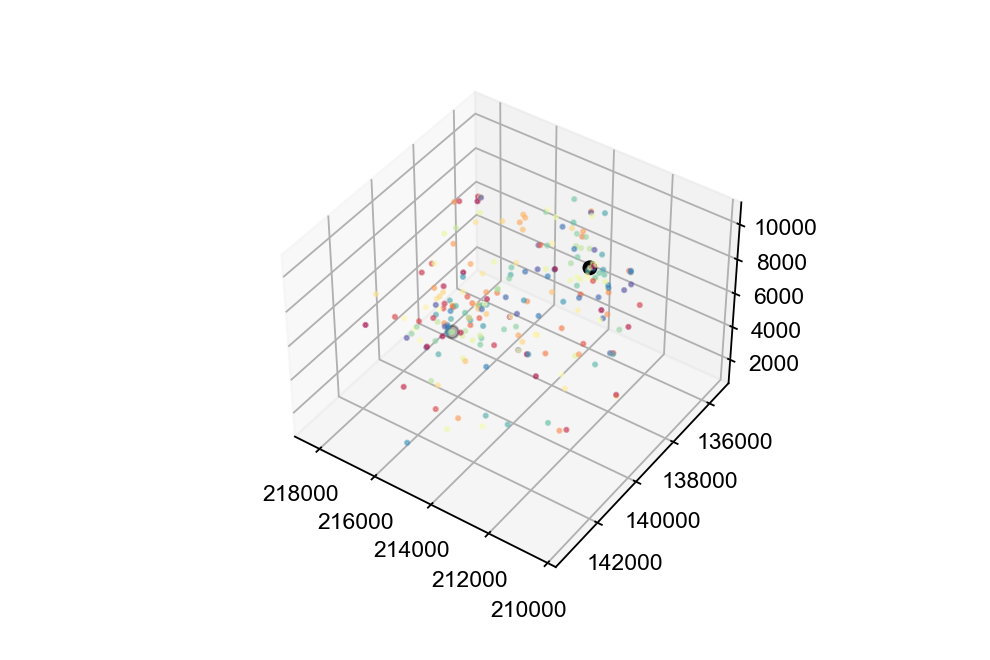

In [747]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')


ax.scatter(_chr_zxys[:,1], _chr_zxys[:,2], _chr_zxys[:,0],
           cmap=Spectral, 
           c=chr_inds,
           #c=homolog_labels,
           alpha=0.5,
           s=3)

ax.scatter(_centers[:,1], _centers[:,2], _centers[:,0],
           cmap=Spectral, 
           color=[0,0,0],
           s=30)

plt.show()

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


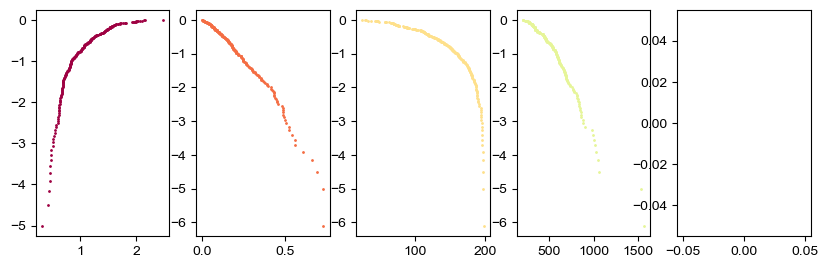

In [597]:
cmap = cm.Spectral
fig, axes = plt.subplots(1,num_score_metrics, figsize=(num_score_metrics*2,3), dpi=100)
#
for _iax, (_ax, _scores) in enumerate(zip(axes, scores_list.transpose())):
    _ax.scatter(np.array(_valid_metrics_list).transpose()[_iax], _scores, s=1, color=cmap(_iax / num_score_metrics))
#axes[1].scatter(valid_inner_dists, _indist_scores, s=1, color='g')
#axes[2].scatter(valid_int_stds, _intstd_scores, s=1, color='b')
fig.show()

In [588]:
for _im, _metrics in enumerate(np.array(_valid_metrics_list).transpose()):
    print(_im, _metrics.shape)

0 (225,)
1 (225,)
2 (225,)
3 (225,)
4 (225,)


In [582]:
fig, axes = plt.subplots(1,3, figsize=(8,3), dpi=100)
#
axes[0].scatter(valid_ints, _int_scores, s=1, color='r')
axes[1].scatter(valid_inner_dists, _indist_scores, s=1, color='g')
axes[2].scatter(valid_int_stds, _intstd_scores, s=1, color='b')
fig.show()


4926 pairs kept given search radius 200 nm.


4926it [00:08, 604.34it/s]


- 2992 spot groups selected. 


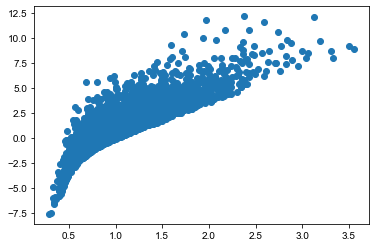

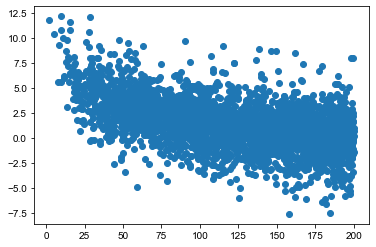

In [422]:
%matplotlib inline

self_scores = decoder.calculate_self_scores(make_plots=True, overwrite=_overwrite)

In [321]:
def _cdf_scores(values, refs, greater=True):
    from scipy import stats
    if greater:
        return np.array([stats.percentileofscore(refs, _v, kind='weak')/100 + 0.5/len(refs) 
                         for _v in values])
    else:
        return np.array([1 - stats.percentileofscore(refs, _v, kind='weak')/100 + 0.5/len(refs) 
                         for _v in values])

In [532]:
_cdf_scores([np.nan], np.nan*np.ones(100))

array([nan])

In [ ]:
def chromosome_2_spots()

In [544]:
decoder.kdtree.query(invalid_groups[0].centroid_spot().to_positions()[0], 10)

(array([267.57038162, 448.58951976, 480.36515936, 492.14907174,
        522.87556617, 582.73135289, 659.0149048 , 664.5332492 ,
        683.69639346, 697.70982638]),
 array([5484,   89,  543, 1681,   66, 1623, 6213, 3449, 5441, 3617]))

In [566]:
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [569]:
decode.generate_score_metrics(decoder.spot_groups[1])

array([  0.91170323,   0.40096253, 117.22502051,          nan,
                nan])

In [526]:
# generate metrics
valid_ints, valid_inner_dists = decoder.generate_reference(decoder.spot_groups)
valid_int_stds = np.array([np.std(_g.intensities())/np.mean(_g.intensities()) for _g in decoder.spot_groups])

In [527]:
_int_scores = _cdf_scores(valid_ints, valid_ints)
_indist_scores = _cdf_scores(valid_inner_dists, valid_inner_dists, greater=False)
_intstd_scores = _cdf_scores(valid_int_stds, valid_int_stds, greater=False)

In [386]:
from scipy.spatial import KDTree
from ImageAnalysis3.classes.preprocess import Spots3D, SpotTuple


# build kd-tree
_tree = KDTree(unused_spots.to_positions())
_nb_dists, _nb_inds = list(_tree.query(unused_spots.to_positions(), 2) )
_invalid_pairs = [SpotTuple(unused_spots[_inds[:2]]) for _inds in _nb_inds]

In [369]:
_nb_ind_sets = [tuple(np.sort(_inds)) for _inds in _nb_inds]

In [536]:
_nb_dists.mean(axis=-1).shape

(2699,)

In [ ]:
def get_scoring_values(spot_group, )

In [517]:
#unused_spots = decoder.find_unused_spots(decoder.cand_spots, decoder.spot_groups)
#invalid_groups = decoder.collect_invalid_pairs(unused_spots,)
# generate metrics
invalid_ints, invalid_inner_dists = decoder.generate_reference(invalid_groups)
invalid_int_stds = np.array([np.std(_g.intensities())/np.mean(_g.intensities()) for _g in invalid_groups])


In [518]:

_int_scores = _cdf_scores(valid_ints, invalid_ints)
_indist_scores = _cdf_scores(valid_inner_dists, invalid_inner_dists, greater=False)
_intstd_scores = _cdf_scores(valid_int_stds, invalid_int_stds, greater=False)

final_scores = np.log(_int_scores) + np.log(_indist_scores) + np.log(_intstd_scores)

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


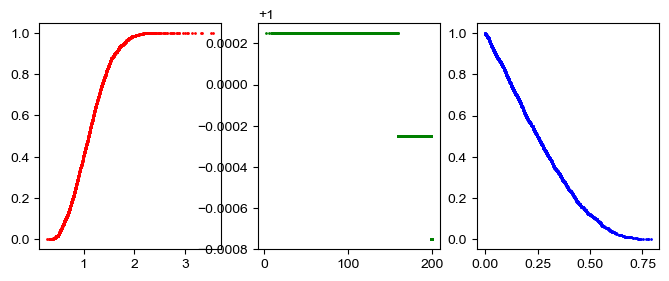

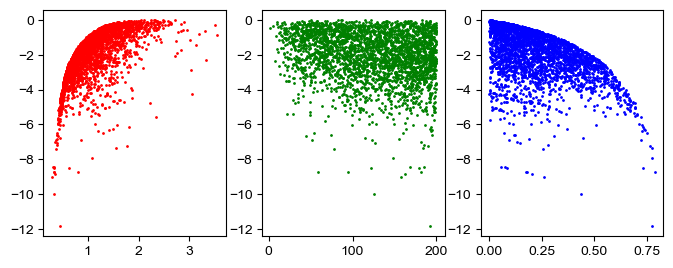

In [519]:
fig, axes = plt.subplots(1,3, figsize=(8,3), dpi=100)
#
axes[0].scatter(valid_ints, _int_scores, s=1, color='r')
axes[1].scatter(valid_inner_dists, _indist_scores, s=1, color='g')
axes[2].scatter(valid_int_stds, _intstd_scores, s=1, color='b')
fig.show()

fig, axes = plt.subplots(1,3, figsize=(8,3), dpi=100)
#
axes[0].scatter(valid_ints, final_scores, s=1, color='r')
axes[1].scatter(valid_inner_dists, final_scores, s=1, color='g')
axes[2].scatter(valid_int_stds, final_scores, s=1, color='b')
fig.show()

In [520]:

_int_scores = _cdf_scores(invalid_ints, valid_ints)
_indist_scores = _cdf_scores(invalid_inner_dists, valid_inner_dists, greater=False)
_intstd_scores = _cdf_scores(invalid_int_stds, valid_int_stds, greater=False)

final_scores = np.log(_int_scores) + np.log(_indist_scores) + np.log(_intstd_scores)

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


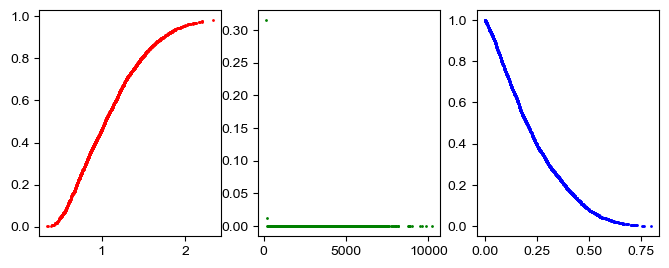

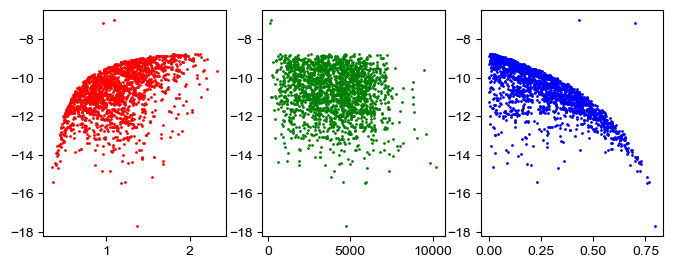

In [521]:
fig, axes = plt.subplots(1,3, figsize=(8,3), dpi=100)
#
axes[0].scatter(invalid_ints, _int_scores, s=1, color='r')
axes[1].scatter(invalid_inner_dists, _indist_scores, s=1, color='g')
axes[2].scatter(invalid_int_stds, _intstd_scores, s=1, color='b')
fig.show()

fig, axes = plt.subplots(1,3, figsize=(8,3), dpi=100)
#
axes[0].scatter(invalid_ints, final_scores, s=1, color='r')
axes[1].scatter(invalid_inner_dists, final_scores, s=1, color='g')
axes[2].scatter(invalid_int_stds, final_scores, s=1, color='b')
fig.show()

In [352]:
cand_cell_dict = pickle.load(open(spot_filenames[-1], 'rb'))
cand_cell_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [294]:
combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}

In [ ]:
for _sp

In [307]:
reload(classes.decode)


<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [308]:
classes.decode.normalize_ch_2_intsannels(cand_cell_dict, id_2_channel)

{1: Spots3D([[ 3.09624100e+00,  1.94454079e+01,  3.15840973e+02,
            1.63860474e+03,  3.16699310e+02,  1.92306519e+00,
            1.50050461e+00,  1.45875299e+00,  2.40403432e-02,
            3.90913159e-01,  4.17488983e+02],
          [ 2.94478750e+00,  1.69295826e+01,  3.04051208e+02,
            1.63035083e+03,  3.71460999e+02,  1.90971327e+00,
            1.59595001e+00,  1.45488179e+00,  3.60541672e-01,
            5.01973450e-01,  3.37983154e+02],
          [ 2.68972397e+00,  1.61380749e+01,  3.18353058e+02,
            1.66832141e+03,  3.00716370e+02,  1.78579366e+00,
            1.99347568e+00,  1.43931389e+00, -7.67859340e-01,
            7.16319382e-01,  4.93856110e+02],
          [ 2.44831491e+00,  2.79945164e+01,  2.81930206e+02,
            1.61533435e+03,  2.14128128e+02,  2.34559393e+00,
            1.57528329e+00,  1.61713529e+00,  1.70825236e-02,
            1.25879318e-01,  3.82848846e+02],
          [ 2.35968232e+00,  1.15855341e+01,  2.48916336e+02,
       

In [ ]:
def scores

In [ ]:
def initialize_homolog_assignment():
    

In [ ]:
_cdf_scores()

4926 pairs kept given search radius 200 nm.


4926it [00:08, 590.21it/s]


- 2992 spot groups selected. 


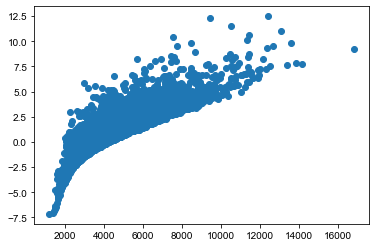

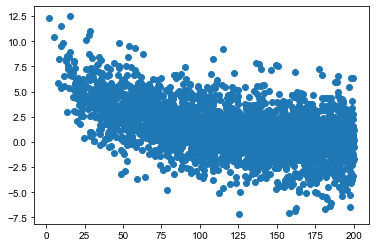

-- seeding chr:1 with 77 regions with 103 spot_groups
- diff in iter-0: 0.6505
- diff in iter-1: 0.0194
- diff in iter-2: 0.0097
- diff in iter-3: 0.0194
- diff in iter-4: 0.0194
- diff in iter-5: 0.0194
- diff in iter-6: 0.0194
- diff in iter-7: 0.0097
- diff in iter-8: 0.0000
-- seeding chr:10 with 51 regions with 67 spot_groups
- diff in iter-0: 0.7164
- diff in iter-1: 0.0597
- diff in iter-2: 0.0299
- diff in iter-3: 0.0299
- diff in iter-4: 0.0000
-- seeding chr:11 with 48 regions with 65 spot_groups
- diff in iter-0: 0.8154
- diff in iter-1: 0.0462
- diff in iter-2: 0.0308
- diff in iter-3: 0.0000
-- seeding chr:12 with 43 regions with 51 spot_groups
- diff in iter-0: 0.7255
- diff in iter-1: 0.0980
- diff in iter-2: 0.0000
-- seeding chr:13 with 45 regions with 62 spot_groups
- diff in iter-0: 0.7097
- diff in iter-1: 0.1290
- diff in iter-2: 0.0484
- diff in iter-3: 0.0323
- diff in iter-4: 0.0000
-- seeding chr:14 with 42 regions with 69 spot_groups
- diff in iter-0: 0.6377
-

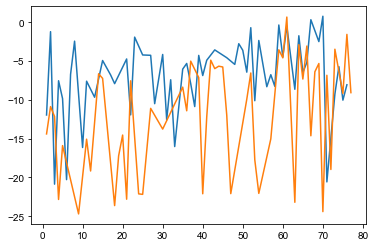

- diff in iter-1: 0.0489


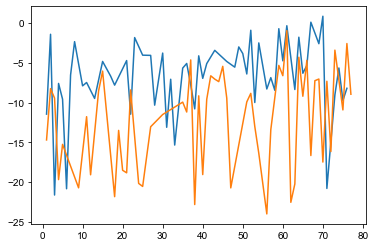

- diff in iter-2: 0.0222


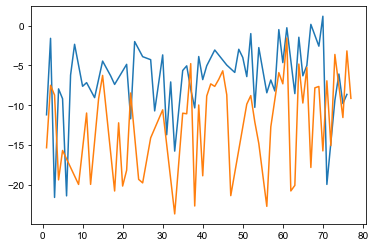

- diff in iter-3: 0.0000


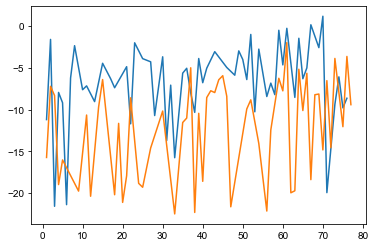

- processing chr:10
- diff in iter-0: 0.4452


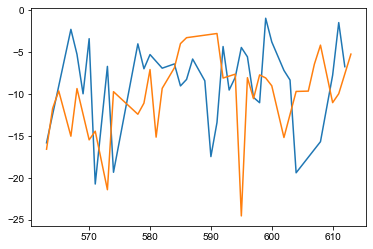

- diff in iter-1: 0.0387


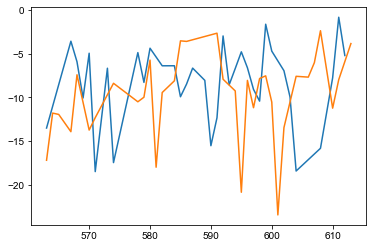

- diff in iter-2: 0.0194


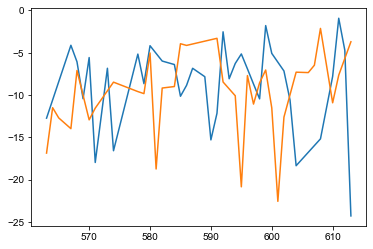

- diff in iter-3: 0.0000


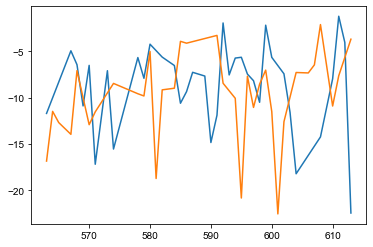

- processing chr:11
- diff in iter-0: 0.5248


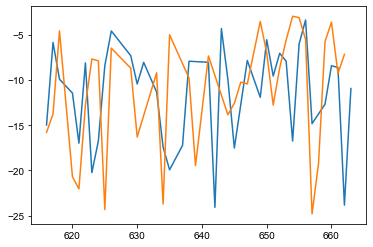

- diff in iter-1: 0.0993


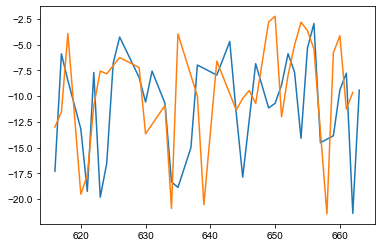

- diff in iter-2: 0.0142


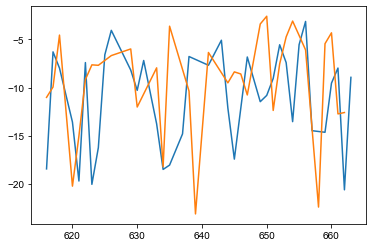

- diff in iter-3: 0.0000


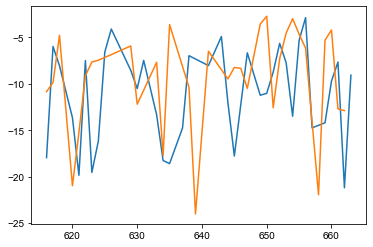

- processing chr:12
- diff in iter-0: 0.4511


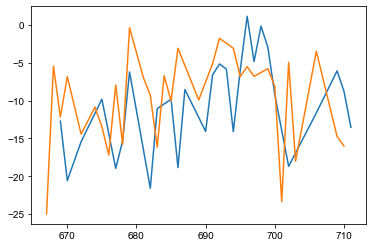

- diff in iter-1: 0.0376


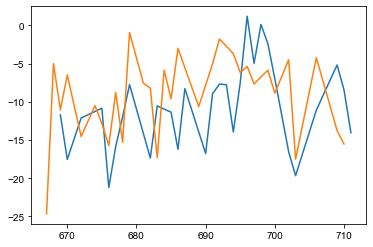

- diff in iter-2: 0.0000


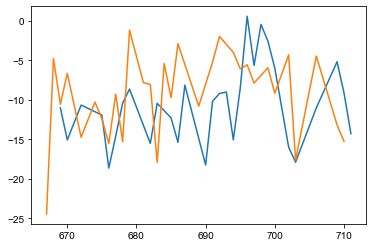

- processing chr:13
- diff in iter-0: 0.5147


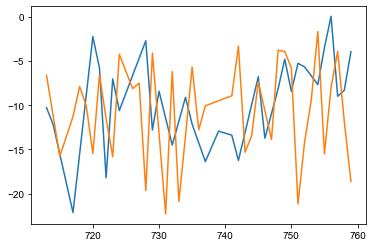

- diff in iter-1: 0.0662


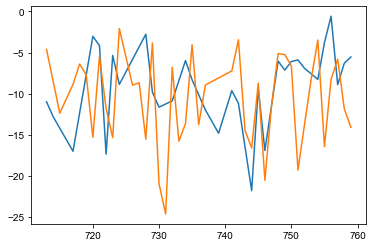

- diff in iter-2: 0.0221


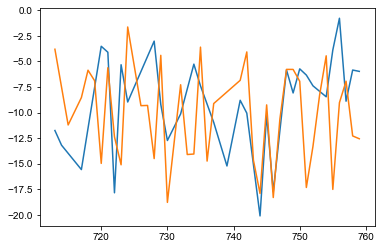

- diff in iter-3: 0.0000


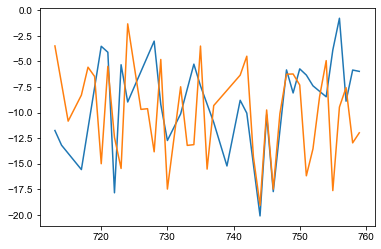

- processing chr:14
- diff in iter-0: 0.4741


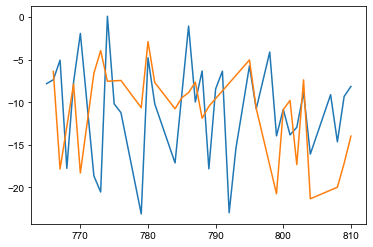

- diff in iter-1: 0.0889


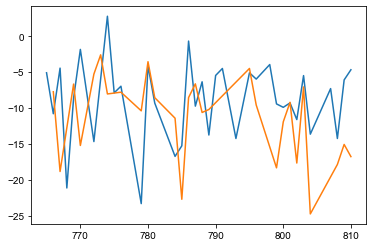

- diff in iter-2: 0.0370


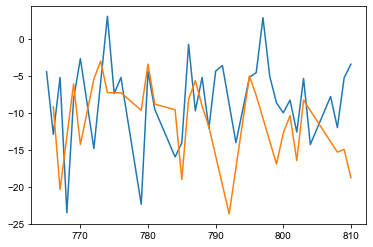

- diff in iter-3: 0.0000


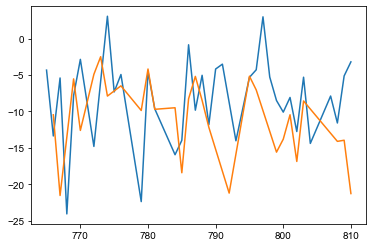

- processing chr:15
- diff in iter-0: 0.4667


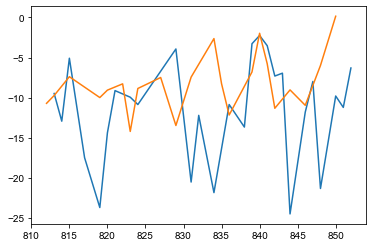

- diff in iter-1: 0.0286


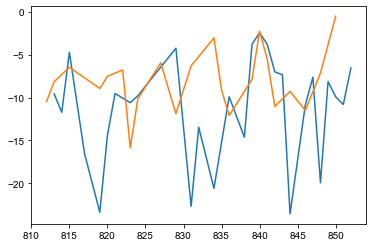

- diff in iter-2: 0.0000


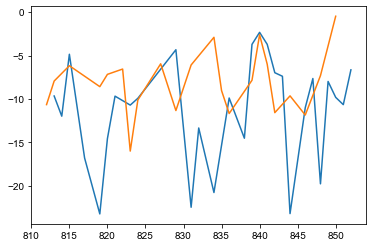

- processing chr:16
- diff in iter-0: 0.4419


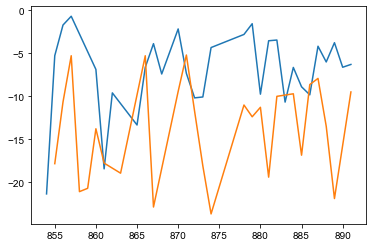

- diff in iter-1: 0.0543


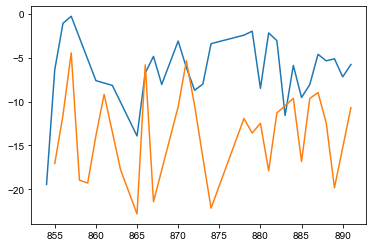

- diff in iter-2: 0.0465


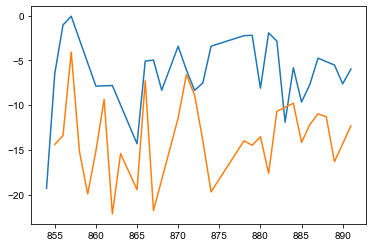

- diff in iter-3: 0.0078


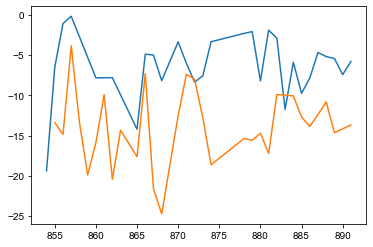

- diff in iter-4: 0.0000


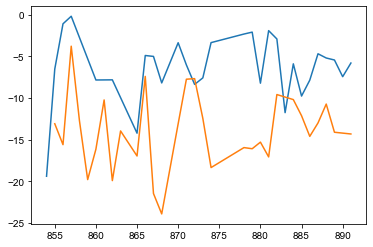

- processing chr:17
- diff in iter-0: 0.4833


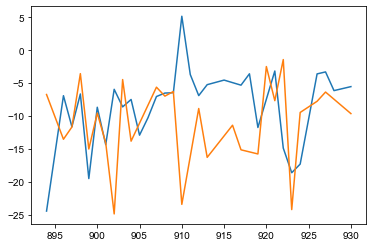

- diff in iter-1: 0.0250


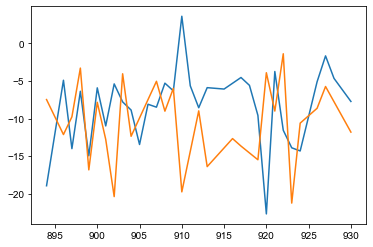

- diff in iter-2: 0.0167


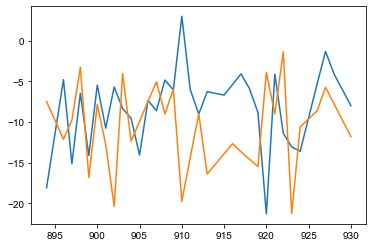

- diff in iter-3: 0.0000


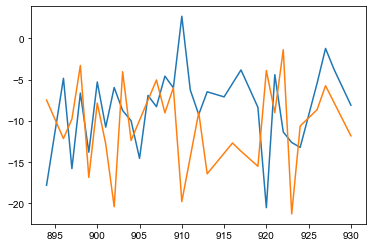

- processing chr:18
- diff in iter-0: 0.4390


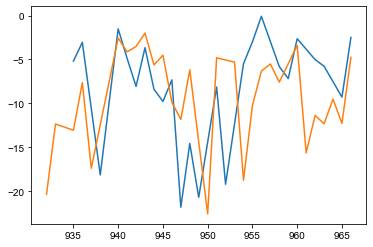

- diff in iter-1: 0.0325


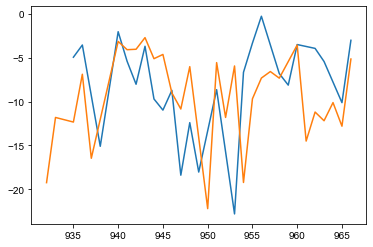

- diff in iter-2: 0.0488


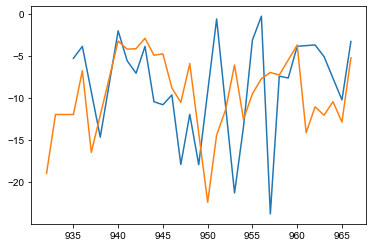

- diff in iter-3: 0.0407


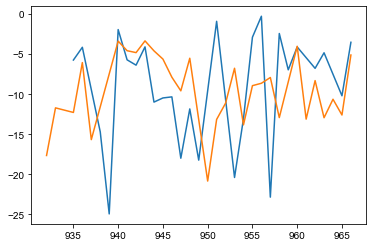

- diff in iter-4: 0.0325


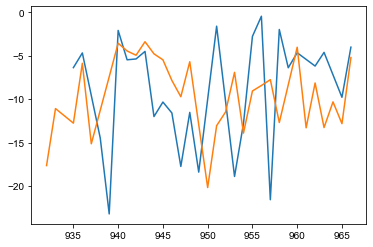

- diff in iter-5: 0.0000


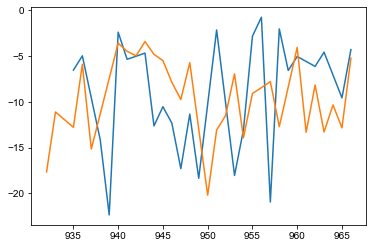

- processing chr:19
- diff in iter-0: 0.4286


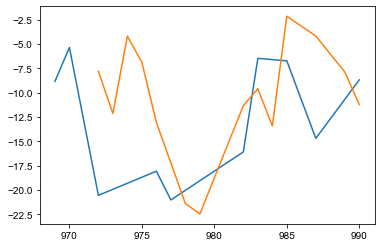

- diff in iter-1: 0.1786


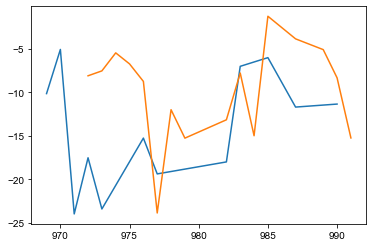

- diff in iter-2: 0.0000


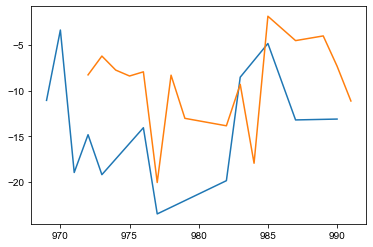

- processing chr:2
- diff in iter-0: 0.4883


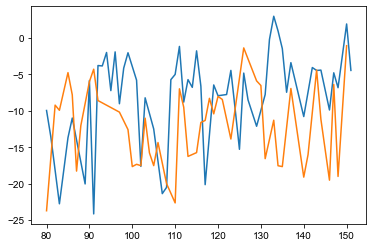

- diff in iter-1: 0.0704


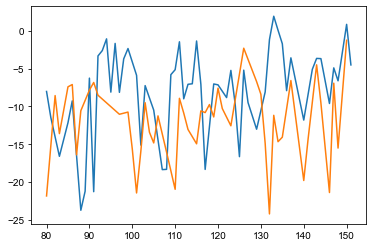

- diff in iter-2: 0.0094


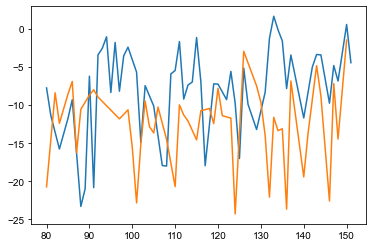

- diff in iter-3: 0.0094


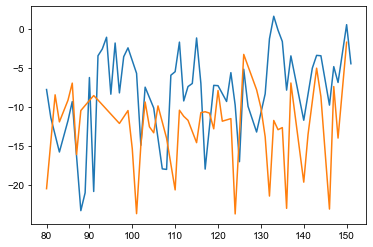

- diff in iter-4: 0.0188


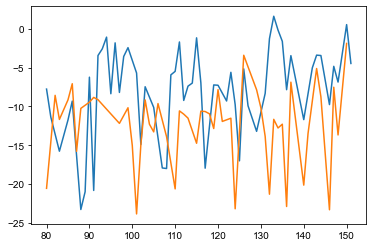

- diff in iter-5: 0.0047


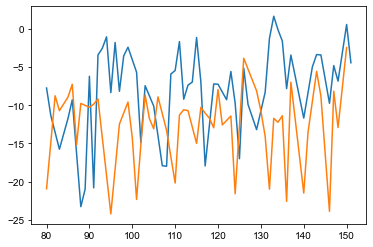

- diff in iter-6: 0.0000


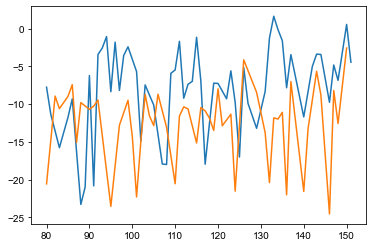

- processing chr:3
- diff in iter-0: 0.4503


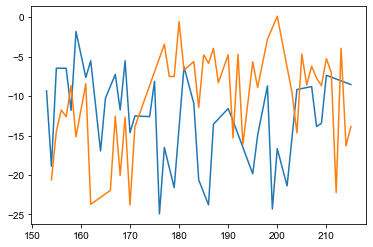

- diff in iter-1: 0.0576


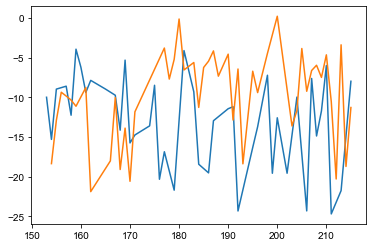

- diff in iter-2: 0.0157


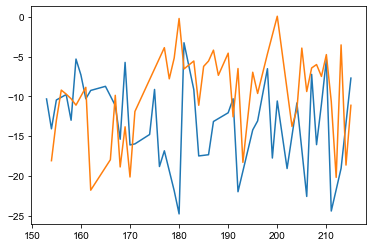

- diff in iter-3: 0.0052


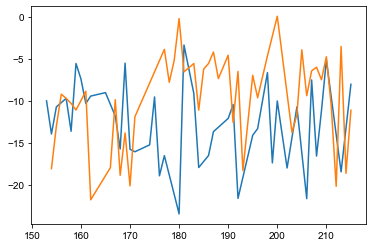

- diff in iter-4: 0.0000


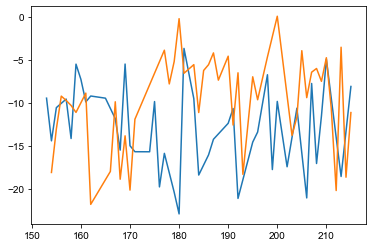

- processing chr:4
- diff in iter-0: 0.5349


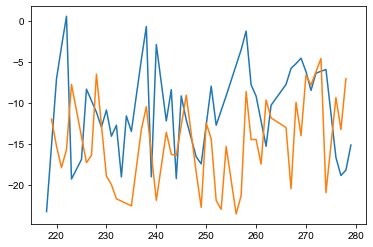

- diff in iter-1: 0.0756


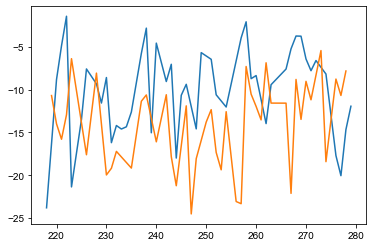

- diff in iter-2: 0.0523


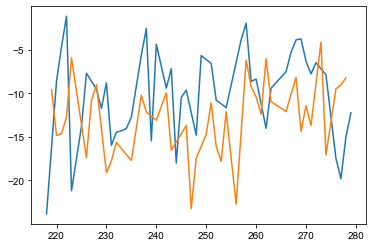

- diff in iter-3: 0.0349


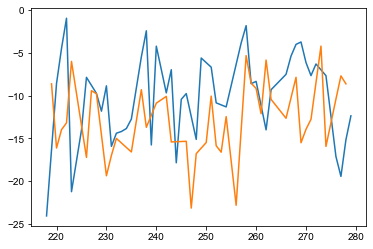

- diff in iter-4: 0.0058


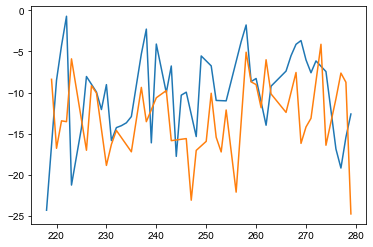

- diff in iter-5: 0.0000


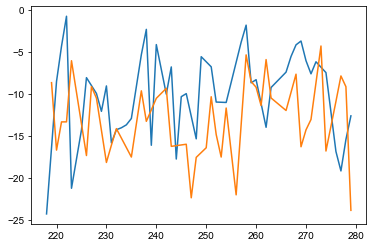

- processing chr:5
- diff in iter-0: 0.5176


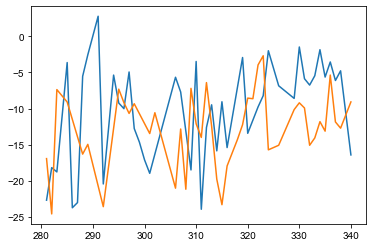

- diff in iter-1: 0.0059


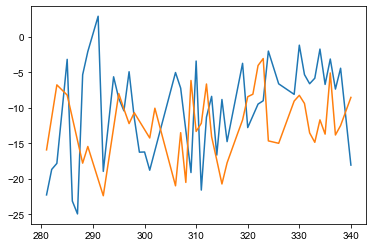

- diff in iter-2: 0.0118


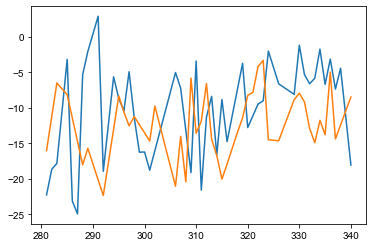

- diff in iter-3: 0.0000


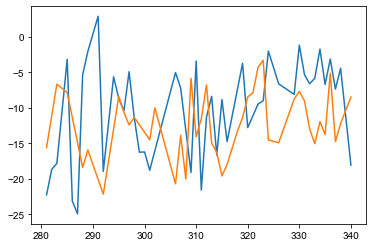

- processing chr:6
- diff in iter-0: 0.4389


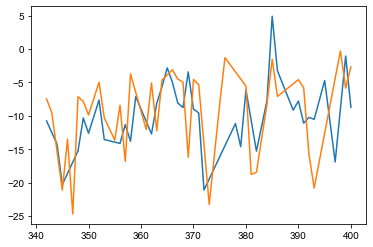

- diff in iter-1: 0.0278


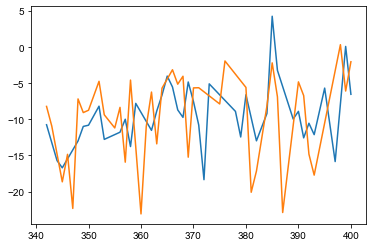

- diff in iter-2: 0.0111


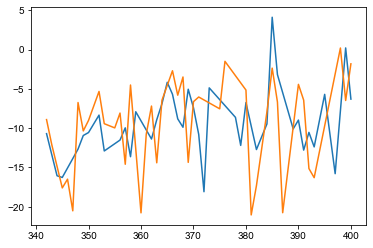

- diff in iter-3: 0.0000


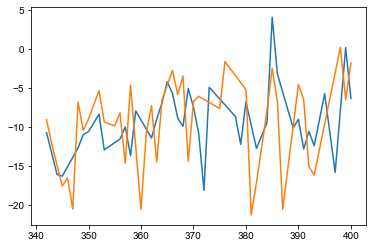

- processing chr:7
- diff in iter-0: 0.5432


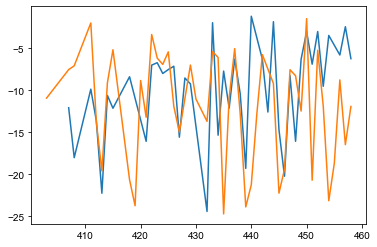

- diff in iter-1: 0.0432


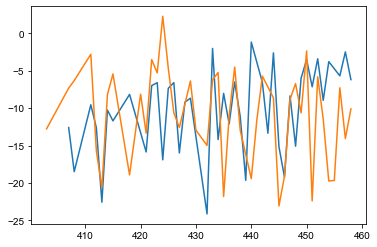

- diff in iter-2: 0.0247


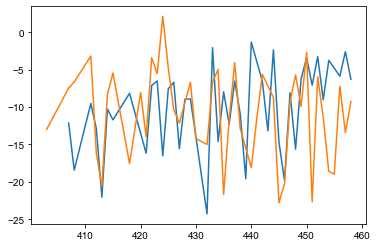

- diff in iter-3: 0.0309


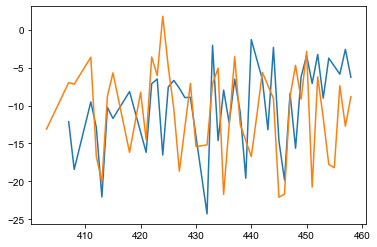

- diff in iter-4: 0.0309


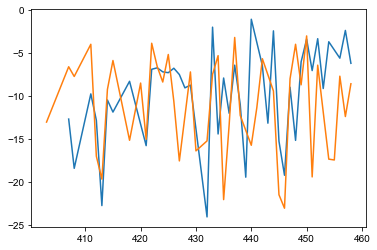

- diff in iter-5: 0.0000


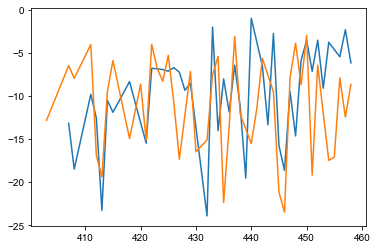

- processing chr:8
- diff in iter-0: 0.5238


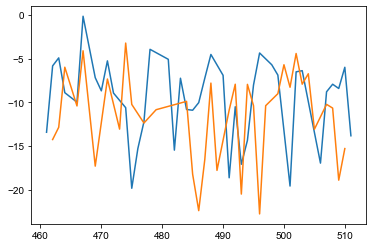

- diff in iter-1: 0.0136


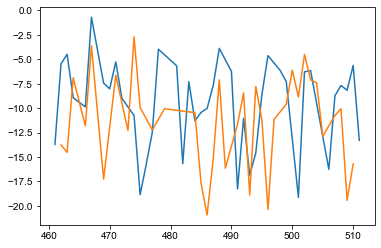

- diff in iter-2: 0.0000


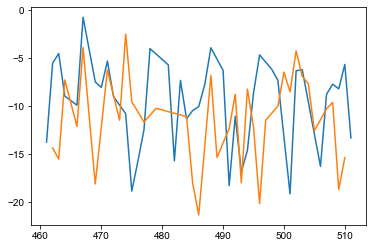

- processing chr:9
- diff in iter-0: 0.4514


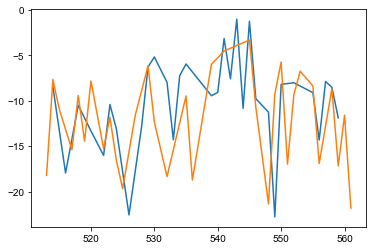

- diff in iter-1: 0.0764


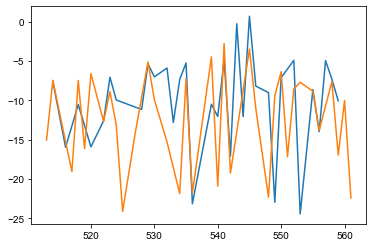

- diff in iter-2: 0.0278


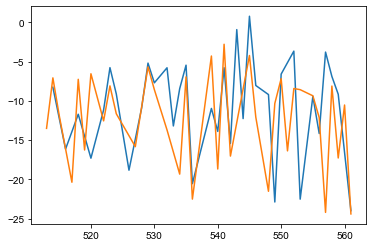

- diff in iter-3: 0.0069


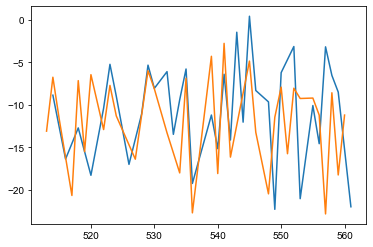

- diff in iter-4: 0.0069


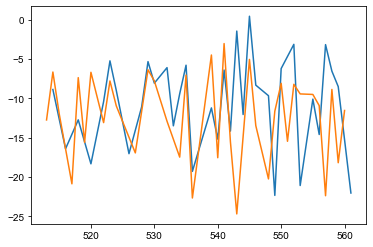

- diff in iter-5: 0.0000


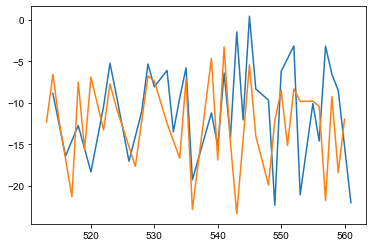

- processing chr:X
- diff in iter-0: 0.5163


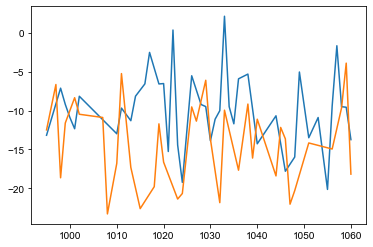

- diff in iter-1: 0.0327


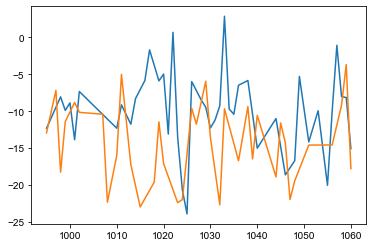

- diff in iter-2: 0.0065


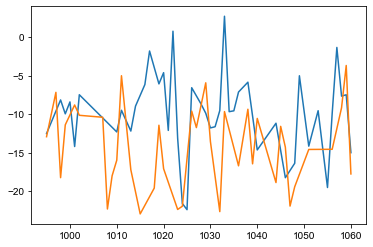

- diff in iter-3: 0.0000


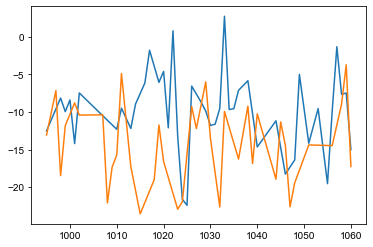

In [200]:


chrs_2_init_centers = decoder.init_homolog_assignment(min_cand_number=10, overwrite=_overwrite)

chr_2_assigned_tuple_list, chr_2_zxys_list, chr_2_chr_centers= \
    decoder.finish_homolog_assignment(plot_stats=True, overwrite=_overwrite, verbose=True)

<IPython.core.display.Javascript object>


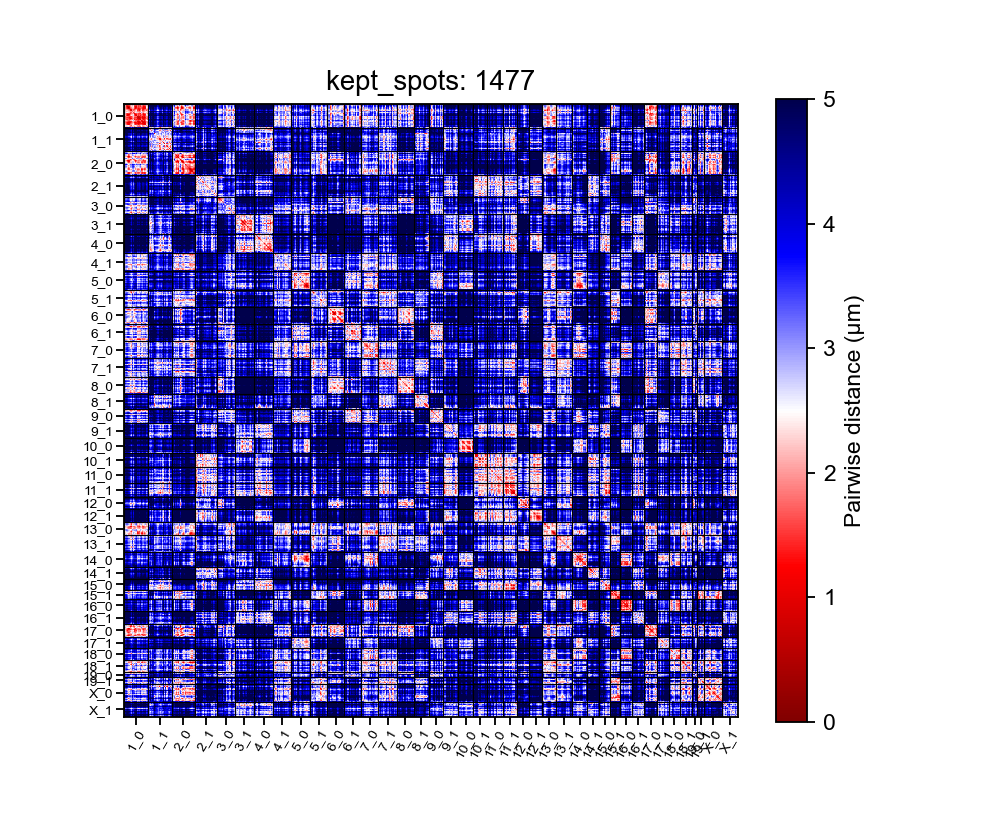

In [201]:
%matplotlib notebook
figure_zxys_list, figure_labels, figure_label_ids = decoder.summarize_zxys_all_chromosomes()

# distmap
#distmap_filename = decoder_filename.replace('Decoder.pkl', 'AllDistmap.png')
_ax = decoder.summarize_to_distmap(decoder, color_limits=[0,5])#, save_filename=distmap_filename) 

In [112]:
def init_homolog_assignment_BB(self, min_cand_number=10, num_homologs=2, 
                               overwrite=True, verbose=True):
    """Use function initial_assign_homologs_by_chr to identify chromosome centers"""

    if not overwrite and hasattr(self, 'chrs_2_init_centers'):
        return getattr(self, 'chrs_2_init_centers')

    # initlaize dict
    chrs_2_init_centers = {}
    #chrs_2_init_zxys_list = {}
    # identify isolated spot_groups as seeds
    seeding_groups = self.find_seeding_groups(self.cand_spots, self.spot_groups,)
    # loop through all chromosomes:
    for _chr_name in np.unique(self.codebook['chr']):

        _chr_region_ids = self.extract_chr_region_ids(self.codebook, _chr_name)

        # extract seeding chromosome spots
        _chr_seeding_groups = [_g for _g in seeding_groups if _g.chr == _chr_name]
        if len(_chr_seeding_groups) < min_cand_number * num_homologs:
            _chr_seeding_groups = [_g for _g in self.spot_groups if _g.chr == _chr_name]
            if verbose:
                print(f"-- seeding chr:{_chr_name} with {len(_chr_region_ids)} regions with *{len(_chr_seeding_groups)} spot_groups")
        else:
            if verbose:
                print(f"-- seeding chr:{_chr_name} with {len(_chr_region_ids)} regions with {len(_chr_seeding_groups)} spot_groups")
        if len(_chr_seeding_groups) < min_cand_number * num_homologs:
            continue

        # run initialize decoding
        init_zxys_list, init_homolog_labels, init_homolog_centers =\
            DNA_Merfish_Decoder.initial_assign_homologs_by_chr(_chr_seeding_groups, _chr_region_ids, num_homologs)
        # save info
        chrs_2_init_centers[_chr_name] = init_homolog_centers
        #chrs_2_init_zxys_list[_chr_name] = init_zxys_list

    # add attribute
    setattr(self, 'chrs_2_init_centers', chrs_2_init_centers)

    return chrs_2_init_centers

    



In [ ]:
def find_prev_neighbors(_cand_tuples_list, _ireg, _reverse=True):
    """Function to find the nearest neighbor"""
    for _i in range
    
    

In [182]:
_chr_name = '1'
_chr_tuples = [_g for _g in decoder.spot_groups if _g.chr==_chr_name]

In [183]:
_chr_region_ids = decoder.extract_chr_region_ids(decoder.codebook, _chr_name)

In [185]:
_ireg = 9
# distribute tuples into region_ids
_cand_tuples_list = [[_g for _g in _chr_tuples if _g.chr_order==_i] 
                    for _i in np.arange(0, np.max(_chr_region_ids)+1)]

_cand_zxys_list = [decoder.tuple_list_to_zxys(_tps) for _tps in _cand_tuples_list]

_reverse=True

print(_ireg, len(_cand_zxys_list[_ireg]))

if _reverse:
    for _jreg in np.flipud(np.arange(0, _ireg)):
        if len(_cand_tuples_list[_jreg]) > 0:
            print(_jreg, len(_cand_tuples_list[_jreg]))
            
            # calculate distances
            _nb_dists = cdist(_cand_zxys_list[_ireg], _cand_zxys_list[_jreg])
        break
            


9 7
8 6


In [169]:
from ImageAnalysis3.spot_tools.scoring import log_distance_scores, exp_distance_scores

In [170]:
_jreg

8

In [186]:
_cand_tuples_list[_jreg]

In [188]:
[_g.homolog for _g in _cand_tuples_list[_jreg]]

[-1, -1, -1, -1, -1, -1]

In [177]:
np.max(exp_distance_scores(_nb_dists))

-19.267039797972792

In [131]:
(_cand_zxys_list)

[array([[  5351.0184288 , 213440.12841797, 140130.29003906],
        [  5828.45211029, 216813.45410156, 138518.72753906],
        [  5031.97431564, 218122.17626953, 141553.35351562],
        [  9267.89569855, 216780.93017578, 137813.55029297],
        [  5910.76135635, 212532.66210938, 137675.47851562],
        [ 10482.28263855, 216328.91748047, 138213.79101562]]),
 array([[  4671.77724838, 216161.27490234, 140475.06738281],
        [  5910.14480591, 214525.91601562, 139417.62451172],
        [  8335.59989929, 212789.42578125, 137724.99609375]]),
 array([[  9939.75830078, 213172.15869141, 138930.08203125],
        [  7688.73071671, 213902.37158203, 138050.18261719],
        [  6288.54656219, 213287.42285156, 136733.43164062],
        [  3373.63600731, 213490.92480469, 139592.25439453],
        [  8339.10751343, 214863.02050781, 136301.03613281],
        [  4899.43218231, 215895.375     , 138354.51269531]]),
 array([[  4303.7276268 , 215900.14746094, 138195.55810547],
        [  6078.34

In [202]:
_dists = pdist(np.concatenate(figure_zxys_list))
plt.figure()
plt.hist(_dists, bins=np.arange(0,10,0.1))
plt.title(f"median:{np.median(_dists):.3f}")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


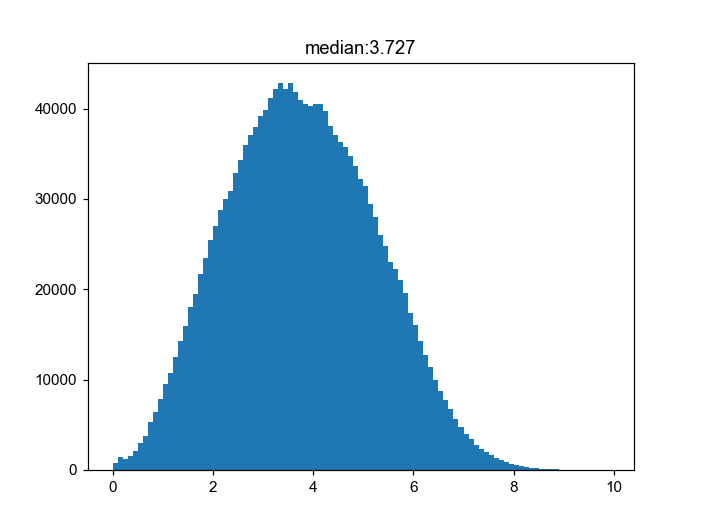

In [78]:
_dists = pdist(np.concatenate(figure_zxys_list))
plt.figure()
plt.hist(_dists, bins=np.arange(0,10,0.1))
plt.title(f"median:{np.median(_dists):.3f}")
plt.show()

<IPython.core.display.Javascript object>


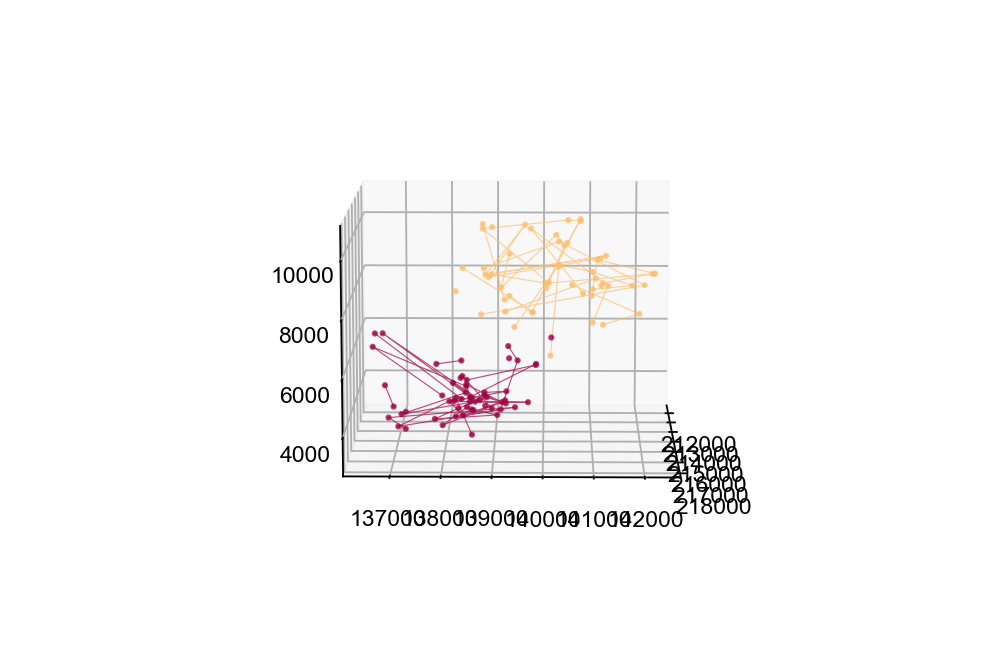

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [225]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
plt.show()

In [ ]:
angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save(os.path.join(figure_folder, 'decoded_cell.gif'), writer=animation.PillowWriter(fps=20))